In [281]:
import time
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import networkx as nx
# import xarray as xr
import seaborn as sns 
# from scipy.special import expit, logit
import scipy as sp
from itertools import combinations
from scipy.spatial.distance import cdist

import os


import jax
import jax.numpy as jnp
from jax import random, jit, vmap
from jax.scipy.special import expit, logsumexp, logit
from functools import partial
import numpyro.distributions as dist 
import numpyro
from numpyro.contrib.funsor import config_enumerate
from numpyro.infer.reparam import LocScaleReparam

from numpyro.util import set_host_device_count
from numpyro.contrib.control_flow import scan
from numpyro.ops.indexing import Vindex
from tqdm import tqdm
from joblib import Parallel, delayed

from numpyro import handlers
from numpyro.infer import MCMC, HMC, NUTS, DiscreteHMCGibbs, MixedHMC, Predictive
import pyro
# import pymc_experimental as pmx

import multiprocessing
import socket
from hsgp.approximation import hsgp_squared_exponential


print(f"Running on PyMC v{pm.__version__}")
# print(f"Running on PyMC-experimental v{pmx.__version__}")
print(f"Running on NumPyro v{numpyro.__version__}")
print(f"Running on Pyro v{pyro.__version__}")
print(f"Running on JAX v{jax.__version__}")


Running on PyMC v5.15.1
Running on NumPyro v0.14.0
Running on Pyro v1.9.0+f02dfb9
Running on JAX v0.4.25


In [282]:
# Set CPU for JAX
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=4"
print(jax.devices('cpu'))

[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3)]


In [283]:
RANDOM_SEED = 89251357143
# rng = np.random.default_rng(RANDOM_SEED)
rng = np.random.default_rng(7)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-white")

(array([1.4646e+04, 1.2220e+04, 8.7350e+03, 5.1430e+03, 2.5040e+03,
        1.0780e+03, 3.7200e+02, 1.1800e+02, 2.9000e+01, 5.0000e+00]),
 array([1.63009288e-04, 1.64900517e+00, 3.29784727e+00, 4.94668961e+00,
        6.59553146e+00, 8.24437332e+00, 9.89321613e+00, 1.15420580e+01,
        1.31908998e+01, 1.48397427e+01, 1.64885845e+01]),
 <BarContainer object of 10 artists>)

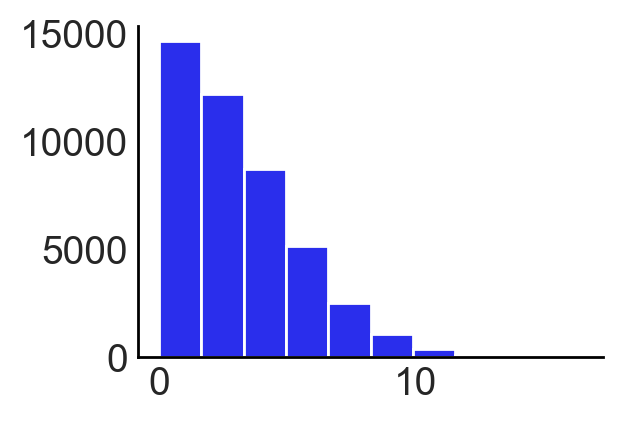

In [284]:
n=300
tril_dim = int(n*(n-1)/2)  
# x = rng.integers(low=0,high=1,size=n,endpoint=True)
x = rng.normal(loc=0,scale=3,size=n)
# x = rng.standard_t(df=10, size= n)
# x = rng.uniform(size=n,low=-3,high=3)
# x = rng.standard_t(size=n,df=5)
x2 = rng.binomial(n=1,p=0.1,size=n)
# x2 = np.random.choice(["A","B","C"], size = n, p=[0.25,0.35,0.6])
# x_diff = []
# # x2_equal =[]
# for i in range(n):
#     for j in range(i+1,n):
#         x_diff.append(np.abs(x[i]-x[j]))
#         # x2_equal.append(x2[i]==x2[j])
# x_diff = np.array(x_diff)
# x2_equal = np.array(x2_equal)
# plt.hist(x_diff)
# Create probs
# beta = -3, -.5,2 
# beta = -2, -.5

idx_pairs = list(combinations(range(len(x)),2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])

x2_equal = jnp.array([1 if x2[i]==1 and x2[j]==1 else 0 for i,j in idx_pairs])
# x2_or = np.array([1 if (x2[i]==1 or x2[j]==1) and (x2[i]!=x2[j]) else 0 for i,j in idx_pairs])
# x2_or = jnp.array([1 if (x2[i]==1 or x2[j]==1) else 0 for i,j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i,j in idx_pairs])

plt.figure(figsize=(3,2))
plt.hist(x_diff)


In [285]:
x2_or.mean()

Array(0.16434783, dtype=float32)

In [286]:
expit(-1*2)

Array(0.11920292, dtype=float32, weak_type=True)

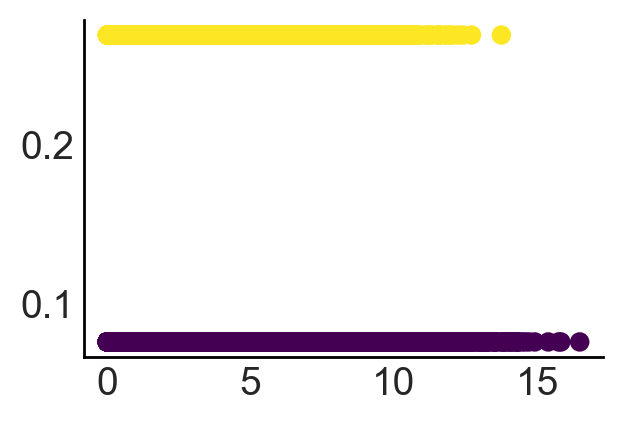

In [287]:
# beta = -2, -.5
beta = -2, -.5
# beta = -2, -1
# probs = expit(beta[0] + beta[1]*x_diff + rng.normal(-.5,1,tril_dim))
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + beta[2]*x2_equal)
# probs = expit(beta[0] + beta[1]*x_diff + 2*x2_or)
probs = expit(-2.5  + 1.5*x2_or)

plt.figure(figsize=(3,2))
plt.scatter(x_diff,probs, c=x2_or)

# Generate adj. matrix
mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges = rng.binomial(n=1,p=probs,size=tril_dim)

mat[idx_ut] = edges
# mat[idx_lt] = edges
mat = mat + mat.T
triu_vals = mat[np.triu_indices(n,k=1)]





In [288]:
# def eigen_centrality(adj_mat):
#     sparse_mat = sp.sparse.csr_matrix(adj_mat)
#     _, eig_vec = sp.sparse.linalg.eigs(sparse_mat, k=1, which = 'LR')
#     largest_v = eig_vec.flatten().real
#     norm = np.sign(largest_v.sum()) * sp.linalg.norm(largest_v)
#     return largest_v / norm

@jit
def eigen_centrality(adj_mat):
    # Ensure the matrix is symmetric
    # adj_mat = (adj_mat + adj_mat.T) / 2
    
    # Compute the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = jnp.linalg.eigh(adj_mat)
    
    # Find the index of the largest eigenvalue
    largest_eigenvalue_index = jnp.argmax(eigenvalues)
    
    # Get the corresponding eigenvector
    largest_eigenvector = eigenvectors[:, largest_eigenvalue_index]
    
    # Scale the eigenvector
    norm = jnp.sign(largest_eigenvector.sum()) * jnp.linalg.norm(largest_eigenvector)
    scaled_eigenvector = largest_eigenvector / norm
    
    return scaled_eigenvector

In [289]:
eigen_center = eigen_centrality(mat)
# eigen_center_jx = eigen_centrality_jax(mat)

# print(jnp.array_equal(jnp.round(eigen_center,5), jnp.round(eigen_center_jx,5)))

# plt.figure(figsize=(3,2))
# plt.scatter(eigen_center, eigen_center_jx)


32.70666666666666


(array([ 50., 154.,  64.,   5.,   0.,   0.,   4.,   7.,  12.,   4.]),
 array([16. , 23.6, 31.2, 38.8, 46.4, 54. , 61.6, 69.2, 76.8, 84.4, 92. ]),
 <BarContainer object of 10 artists>)

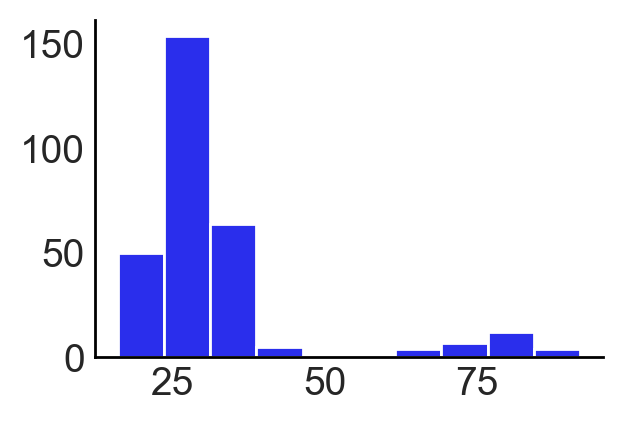

In [290]:
plt.figure(figsize=(3,2))
print(np.mean(np.sum(mat,axis=1)))
plt.hist(np.sum(mat,axis=1))

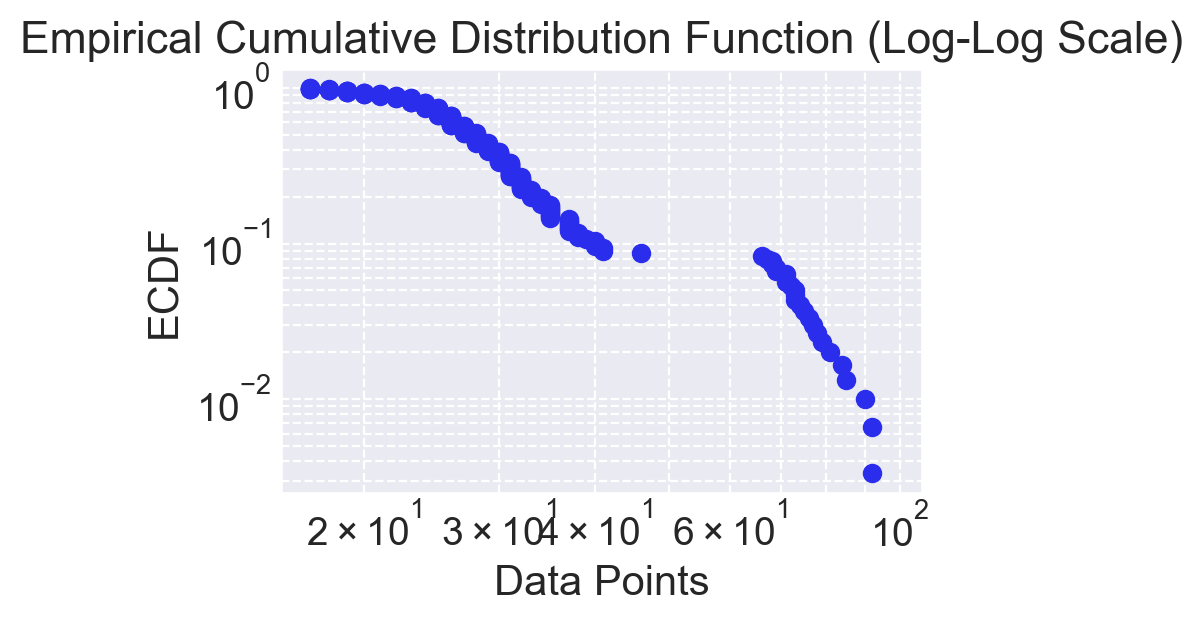

In [259]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

deg_, cdf_ = ecdf(np.sum(mat,axis=1))

plt.figure(figsize=(4, 3))
plt.scatter(deg_, 1-cdf_)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Data Points')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function (Log-Log Scale)')
plt.grid(True, which='both', linestyle='--')
plt.show()


sum eigen 16.282387


(array([ 39., 113.,  93.,  26.,   3.,   3.,  11.,   6.,   4.,   2.]),
 array([0.02687924, 0.0383862 , 0.04989316, 0.06140012, 0.07290708,
        0.08441404, 0.09592099, 0.10742795, 0.11893491, 0.13044187,
        0.14194883]),
 <BarContainer object of 10 artists>)

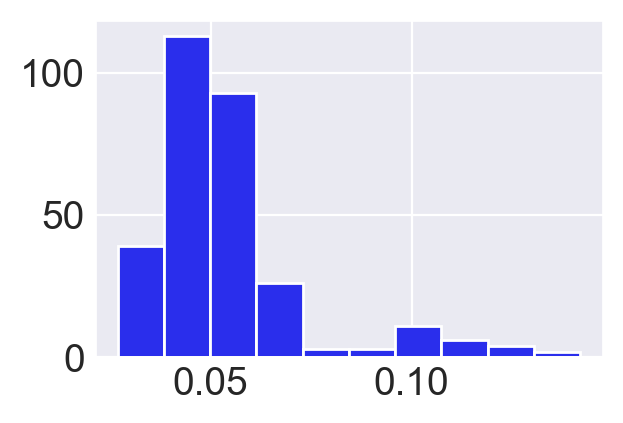

In [260]:
print("sum eigen", np.sum(eigen_center))
plt.figure(figsize=(3,2))
plt.hist(eigen_center)

In [128]:
# mat_net = nx.from_numpy_array(mat)
# 
# degrees = np.array([degree for _, degree in mat_net.degree()])
# deg_center = np.array(list(nx.degree_centrality(mat_net).values()))
# eigen_center = np.array(list(nx.eigenvector_centrality_numpy(mat_net).values()))
# closeness = np.array(list(nx.closeness_centrality(mat_net).values()))
# betweeness = np.array(list(nx.betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.current_flow_betweenness_centrality(mat_net).values()))
# # flow_betweeness = np.array(list(nx.approximate_current_flow_betweenness_centrality(mat_net,epsilon=0.1).values()))
# triangles = np.array(list(nx.triangles(mat_net).values()))
# clustering = np.array(list(nx.clustering(mat_net).values()))


In [ ]:
# print(min(betweeness),max(betweeness))
# print(min(eigen_center),max(eigen_center))
# print(min(triangles),max(triangles))


In [39]:
@jit
def zeigen_value(Z, eig_cen, A_mat):
    if Z.ndim == 1:  # Case when Z has shape (N,)
        return jnp.dot(A_mat, Z * eig_cen)
    elif Z.ndim == 2:  # Case when Z has shape (M, N)
        return jnp.dot(Z * eig_cen, A_mat.T)  # Transpose A_mat for correct dimensions
    # return jnp.dot(Z*eig_cen, A_mat.T)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, Z*eig_cen)
    # return jnp.dot(A_mat, jnp.multiply(Z, eig_cen))

           zeigen       expos     exposinv           Z
count  300.000000  300.000000   300.000000  300.000000
mean     1.004846    0.498078   625.473333    0.516667
std      0.427423    0.093312   245.437653    0.500557
min      0.273440    0.250000   173.000000    0.000000
25%      0.736964    0.428571   468.750000    0.000000
50%      0.919597    0.500000   579.000000    1.000000
75%      1.129394    0.556373   719.250000    1.000000
max      2.562667    0.842105  1509.000000    1.000000
[[1.         0.43942066]
 [0.43942066 1.        ]]


(array([ 10.,  62., 103.,  63.,  28.,   7.,   5.,   8.,   9.,   5.]),
 array([0.27343953, 0.50236225, 0.73128498, 0.96020764, 1.18913043,
        1.41805315, 1.64697576, 1.87589848, 2.10482121, 2.33374405,
        2.56266665]),
 <BarContainer object of 10 artists>)

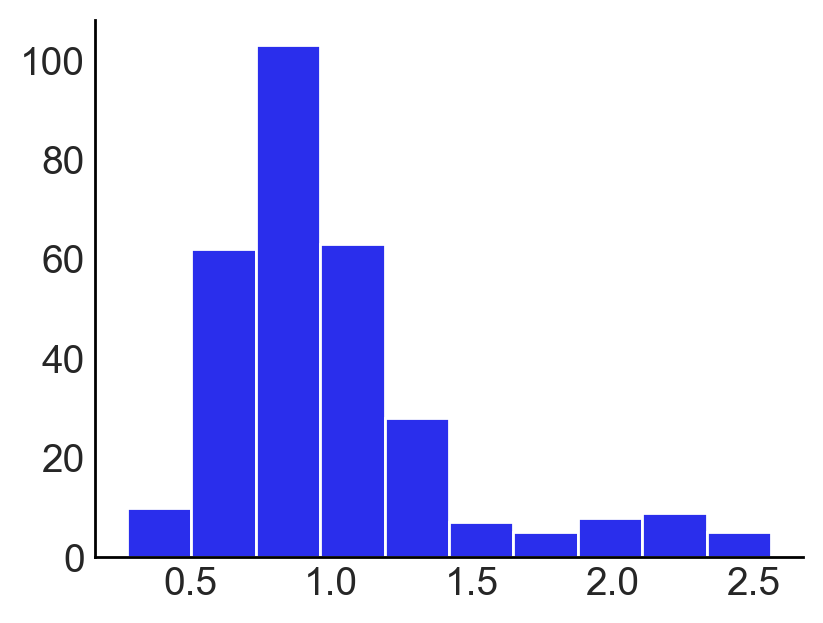

In [291]:
# Create outcome data

Z = rng.binomial(n=1,p=0.5,size=n)
degrees = np.sum(mat,1)
exposures = np.dot(mat,Z) / degrees
exposures_inv_deg = np.dot(mat,Z*degrees)
# print(pd.DataFrame(exposures).describe())
# x_neighbors = np.dot(mat,x) / degrees
# print(pd.DataFrame(x_neighbors).describe())
# print(pd.DataFrame(x).describe())

# Zeigen = np.dot(mat, Z*eigen_center)
Zeigen = zeigen_value(Z, eigen_center, mat)

print(pd.DataFrame({"zeigen": Zeigen,"expos" : exposures, "exposinv":exposures_inv_deg,
                    "Z" : Z}).describe())
print(np.corrcoef(Zeigen,exposures))
# expos_binary = exposures > 0.5
# print(np.mean(expos_binary))

plt.figure(figsize=(4,3))
plt.hist(Zeigen)
# plt.scatter(exposures, Zeigen)
# plt.scatter(exposures_inv_deg, exposures)

In [292]:
oned = zeigen_value(Z, eigen_center, mat)
multid = zeigen_value(Z.reshape((1,n)), eigen_center, mat)
multid_m = jnp.mean(multid, axis=0)
print(oned.shape)
print(multid.shape)
print(multid_m.shape)
print(jnp.array_equal(jnp.round(oned, 4), jnp.round(multid_m,4)))

(300,)
(1, 300)
(300,)
True


In [293]:
np.mean(Zeigen > 0.9)

Array(0.54, dtype=float32)

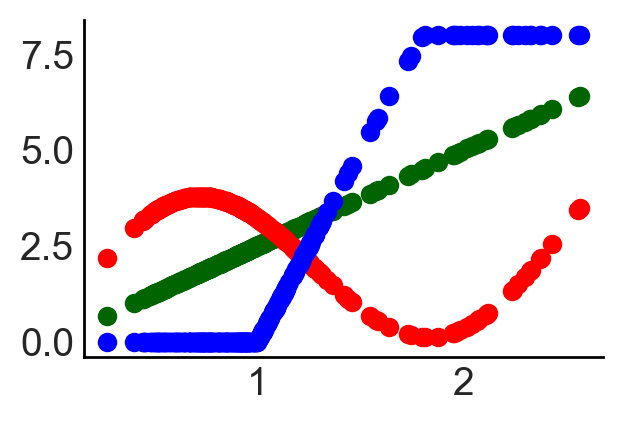

In [294]:
s = np.sort(Zeigen)
# f1 = 2.5*s
# f2 = 0*(x < 0.25) + 0.2*np.exp(2*x)*(x>=0.25)
# f2 = 0*(s < 0.2) + 5*2.5*np.power(s-0.2, 2)*(s>=0.2)

def f2(s):
    return np.piecewise(s, 
                        [s < 1, (s >= 1) & (s < 1.8), s >= 1.8], 
                        # [lambda s: 0, lambda s: 15*2.5*np.power(s-0.3, 2), 15*2.5*np.power(0.6-0.3, 2)])
                        [lambda s: 0, lambda s: 4*2.5*(s-1), 4*2.5*(1.8-1)])

def f(x):
    # return 2.5*(np.sin(10 * x) + np.cos(3 * x))
    # return 2.5*(np.sin(4*np.pi * x) + np.log(x+1))
    return 2.5*(np.sin(2.5* x) + np.log(x + 1))


f0 = 2.5*s
f1 = f(s)
f2v= f2(s)
f3 = 2.5*1.5 / (1+np.exp(-15*(s-0.4)))

plt.figure(figsize=(3,2))
plt.scatter(s,f0, c="darkgreen")
plt.scatter(s,f1, c="red")
plt.scatter(s,f2v, c="blue")
# plt.scatter(s,f3, c="violet")
# plt.axvline(0.25, c="black")


In [18]:
f2(np.array(Zeigen))

array([4.        , 4.        , 4.        , 1.7597101 , 4.        ,
       1.726285  , 4.        , 0.        , 3.7448874 , 4.        ,
       4.        , 4.        , 4.        , 3.6321137 , 4.        ,
       1.4631965 , 4.        , 4.        , 0.        , 0.42496204,
       3.6006162 , 4.        , 1.45947   , 4.        , 4.        ,
       4.        , 0.        , 2.043924  , 4.        , 3.8868954 ,
       4.        , 3.3507373 , 2.018492  , 2.021775  , 2.098231  ,
       3.7185206 , 4.        , 0.        , 2.5105371 , 4.        ,
       1.0900512 , 4.        , 0.8279744 , 4.        , 0.        ,
       0.        , 0.        , 4.        , 3.2750282 , 0.        ,
       2.960907  , 0.36338866, 0.15355319, 3.5158422 , 4.        ,
       3.2507327 , 4.        , 3.0849335 , 0.        , 0.77988   ,
       0.74671566, 0.        , 4.        , 1.3804731 , 1.6866157 ,
       4.        , 0.28737098, 0.        , 4.        , 4.        ,
       0.        , 0.        , 4.        , 3.4199884 , 0.14913

In [355]:
# alpha = -.5, 2, 1, -1
# alpha = -1, 3, 1, 0.5, -0.25
# alpha = -.5, 2, .5, 0.25, -0.25
# alpha = -.5, 2, 0.5, -0.25, -0.25
# alpha = -2, 3, 1, -.5
# alpha = -1, 3, 2, -.25, 5, 5 
# alpha = -1, 3, -.25, 2.5, 2 

def f_zeigen(s, param):
    # Conditions
    cond1 = s < 0.4
    cond2 = (s >= 0.4) & (s < 0.8)
    cond3 = s >= 0.8
    # Functions
    f1 = 0
    f2 = 4 * param * (s - 0.4)
    f3 = 4 * param * (0.8 - 0.4)
    # Using jnp.where to implement piecewise function
    result = jnp.where(cond1, f1, jnp.where(cond2, f2, f3))
    return result

# alpha = -1, 3, -.25, 3, 2.5 
alpha = -1, 3, -.25, 0, 2.5 

def gen_y(df_lin, Zeigen, alpha, lin=True):
    Nn = Zeigen.shape[0]
    epsi = rng.normal(loc=0,scale=.5,size=Nn)
    if lin:
        mean_y = np.dot(np.column_stack((df_lin,Zeigen)), alpha)
    else:
        mean_lin = np.dot(df_lin, alpha[0:4]) 
        # mean_nonlin = 0*(Zeigen < 0.2) + (alpha[3]*3)*(Zeigen-0.2)*(Zeigen>=0.2)        
        # mean_nonlin = 0*(Zeigen < 0.2)  - alpha[3]*(np.log(1-(Zeigen-0.2)/1.1))*(Zeigen>=0.2)        
        # mean_nonlin = alpha[3]*1.5 / (1+np.exp(-15*(Zeigen-0.4)))        
        # mean_nonlin = alpha[3]*(np.sin(10 * Zeigen) + np.log(Zeigen + 1))
        # mean_nonlin = alpha[4]*(np.sin(2.5 * Zeigen) + np.log(Zeigen + 1))        
        mean_nonlin = f_zeigen(Zeigen, alpha[4])        
        # mean_nonlin = alpha[3]*(np.sin(15 * Zeigen) + 2*np.log(Zeigen + 1))        
        # mean_nonlin = alpha[3]*(np.sin(4*np.pi * Zeigen) + np.log(Zeigen + 1))        
        mean_y = mean_lin + mean_nonlin

    Y = mean_y + epsi
    return Y, epsi



(array([ 50., 154.,  64.,   5.,   0.,   0.,   4.,   7.,  12.,   4.]),
 array([16. , 23.6, 31.2, 38.8, 46.4, 54. , 61.6, 69.2, 76.8, 84.4, 92. ]),
 <BarContainer object of 10 artists>)

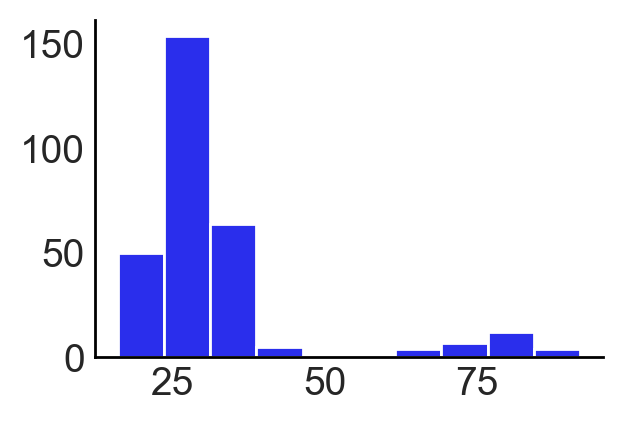

In [296]:
plt.figure(figsize=(3,2))
plt.hist(degrees)

(array([11., 31., 52., 54., 56., 56., 25., 10.,  4.,  1.]),
 array([-1.0970292 , -0.03946051,  1.01810818,  2.07567688,  3.13324557,
         4.19081426,  5.24838295,  6.30595165,  7.36352034,  8.42108903,
         9.47865773]),
 <BarContainer object of 10 artists>)

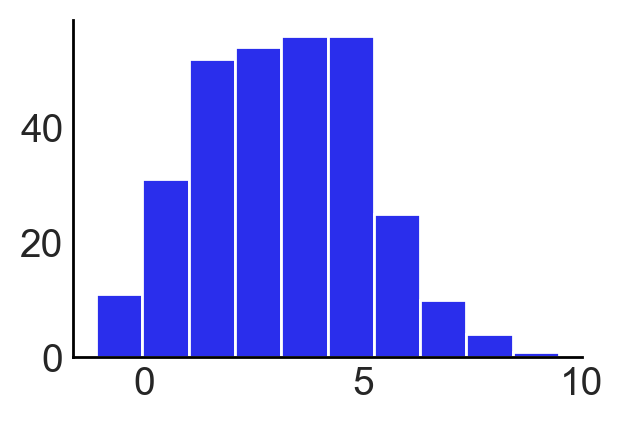

In [400]:
# df_array = np.transpose(np.array([[1]*n,Z,exposures,x,eigen_center,betweeness]))
# df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen,exposures]))

df_array = np.transpose(np.array([[1]*n, Z, x, Zeigen]))
# df_array = np.transpose(np.array([[1]*n, Z, x,x2, Zeigen]))

df_lin = np.transpose(np.array([[1]*n, Z, x, x2]))
# mean_y = np.dot(df_array,alpha)
# # Y = alpha[0] + alpha[1]*Z + alpha[2]*exposures + alpha[3]*x + alpha[4] + rng.normal(loc=0,scale=1,size=n)
# epsilon = rng.normal(loc=0,scale=1,size=n)
# Y = mean_y + epsilon

# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)
# Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=False)
Y, epsilon = gen_y(df_lin, Zeigen, alpha, lin=True)

plt.figure(figsize=(3,2))
plt.hist(Y)


[[1.         0.47221347]
 [0.47221347 1.        ]]


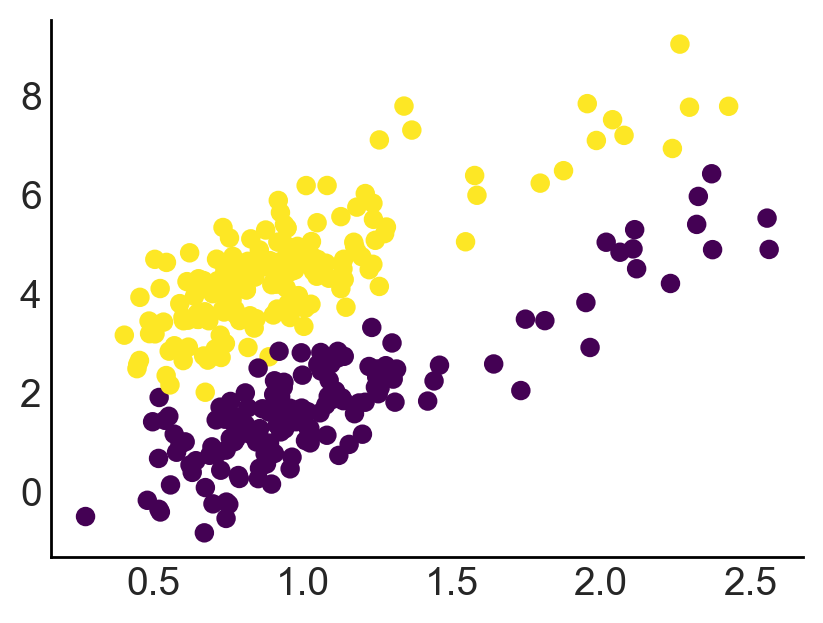

In [359]:
plt.figure(figsize=(4,3))
# plt.scatter(exposures,betweeness)
# plt.scatter(exposures,eigen_center)

# print(np.corrcoef(eigen_center,Zeigen))
print(np.corrcoef(Zeigen,Y))
# plt.scatter(eigen_center,Zeigen)
plt.scatter(Zeigen,Y-epsilon,c=Z)
# plt.scatter(exposures,Zeigen)
# plt.scatter(exposures/degrees,Zeigen)
# plt.scatter(betweeness,eigen_center)
# plt.hist(Zeigen)
# plt.hist(exposures/degrees)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\bar21\.conda\envs\STAT\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


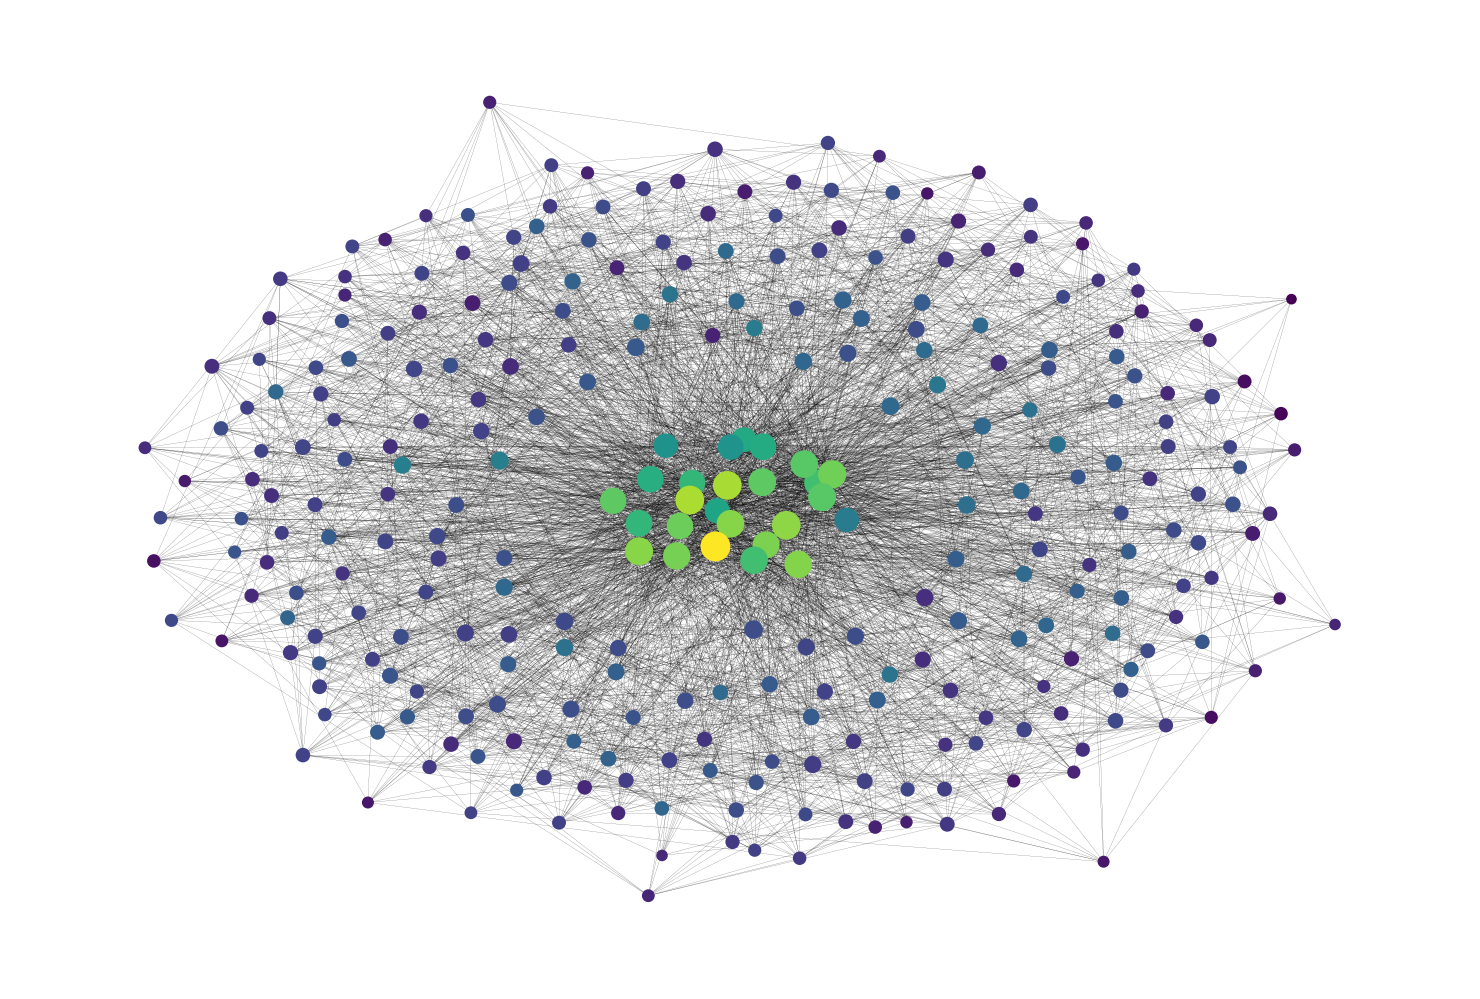

In [246]:
DG = nx.from_numpy_array(mat)
nx.set_node_attributes(DG, Z, "Treatments") 
node_sizes = [DG.degree(node) for node in DG.nodes()]
# nx.draw(DG,node_color = Z, node_size=node_sizes, width=0.05)
# nx.draw(DG, nx.kamada_kawai_layout(DG), node_color = eigen_center, node_size=node_sizes, width=0.05)
nx.draw(DG, nx.kamada_kawai_layout(DG), node_color = Zeigen, node_size=node_sizes, width=0.05)
# nx.draw(DG, nx.shell_layout(DG), node_color = Zeigen, node_size=node_sizes, width=0.05)
plt.legend()
plt.show()

In [491]:
# Create noisy measurement of `mat`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma1 = 0.25  # Remove existing edge with prob `alph`
# gamma2 = 0.01
# 
# # gamma0 = gamma1/5 # add non-existing edge with prob `bet` 
# # gamma0 = 0.05 # add non-existing edge with prob `bet` 
# gamma0 = 0.025 # add non-existing edge with prob `bet` 
# 
# obs_mat = np.zeros((n,n)) # create nXn matrix of zeros
# # obs_mat[np.tril_indices(n=n,k=-1)] = tril_vals # init as true network
# obs_mat[np.triu_indices(n=n,k=1)] = triu_vals # init as true network
# for i in range(0,n): # add noise
#     for j in range(i+1,n):
#         if mat[i,j] == 1:
#             # obs_mat[i,j] = rng.binomial(n=1,p=1-gamma1,size=1)[0] # retain existing edge w.p. `1-gamma1`
#             obs_mat[i,j] = rng.binomial(n=1,p=1-expit(2 - 3*x_diff[]),size=1)[0] # retain existing edge w.p. `1-gamma1`
#         else:
#             obs_mat[i,j] = rng.binomial(n=1,p=gamma0,size=1)[0] # add non-existing edge w.p. `gamma0` 
#             
# obs_mat = obs_mat + obs_mat.T
# triu_obs = obs_mat[np.triu_indices(n=n,k=1)]
# # tril_obs = obs_mat[np.tril_indices(n=n,k=-1)]


In [493]:
print(logit(1-0.25), expit(1.1), expit(-1), expit(-3.5), expit(-1))

1.0986123 0.7502601 0.26894143 0.02931223 0.26894143


In [298]:
# prob_nois = triu_vals*(1-0.3) + (1-triu_vals)*expit(-1 - .25*x_diff)
# logit_nois = triu_vals*logit(1-0.25) + (1-triu_vals)*(-1.5 - .1*x_diff + .5*x2_equal)
# logit_nois = triu_vals*logit(1-0.25) + (1-triu_vals)*(-2.5 - 1*x2_equal)
# logit_nois = triu_vals*logit(1-0.2) + (1-triu_vals)*(-2 + 1*x2_equal + 0.5*x2_or)
# logit_nois = triu_vals*logit(1-0.2) + (1-triu_vals)*(-2 + 1*x2_equal + 0.5*x2_or)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-2 + 1.5*x2_or)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-2 - .15*x_diff)
logit_nois = triu_vals*1.1 + (1-triu_vals)*(-1*x_diff)
# logit_nois = triu_vals*1.1 + (1-triu_vals)*(-2)
# logit_nois = triu_vals*logit(0.75) + (1-triu_vals)*(-4  - .5*x_diff)

# prob_nois = triu_vals*(1-0.25) + (1-triu_vals)*0.05
obs_mat = np.zeros((n,n))
# idx_lt = np.tril_indices(n=n,k=-1)
idx_ut = np.triu_indices(n=n,k=1)
# edges = rng.binomial(n=1,p=0.5,size=tril_dim)
edges_noisy = rng.binomial(n=1,p=expit(logit_nois),size=tril_dim)

obs_mat[idx_ut] = edges_noisy
# mat[idx_lt] = edges
obs_mat = obs_mat + obs_mat.T
triu_obs = obs_mat[np.triu_indices(n,k=1)]

print(np.array_equal(triu_obs, edges_noisy))


True


59.32


(array([15., 23., 41., 52., 64., 65., 22., 13.,  4.,  1.]),
 array([ 21. ,  30.2,  39.4,  48.6,  57.8,  67. ,  76.2,  85.4,  94.6,
        103.8, 113. ]),
 <BarContainer object of 10 artists>)

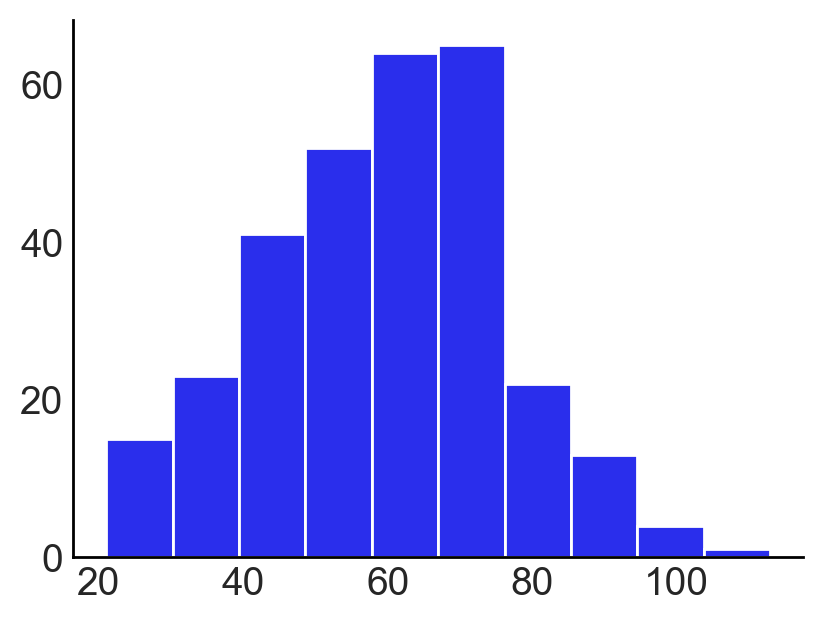

In [299]:
# Plot noisy observed network 
# DG_noise = nx.from_numpy_array(obs_mat)
# nx.draw(DG_noise, with_labels=True,  node_color = Z)
# plt.show()
plt.figure(figsize=(4,3))
print(np.mean(np.sum(obs_mat,1)))
plt.hist(np.sum(obs_mat,1))

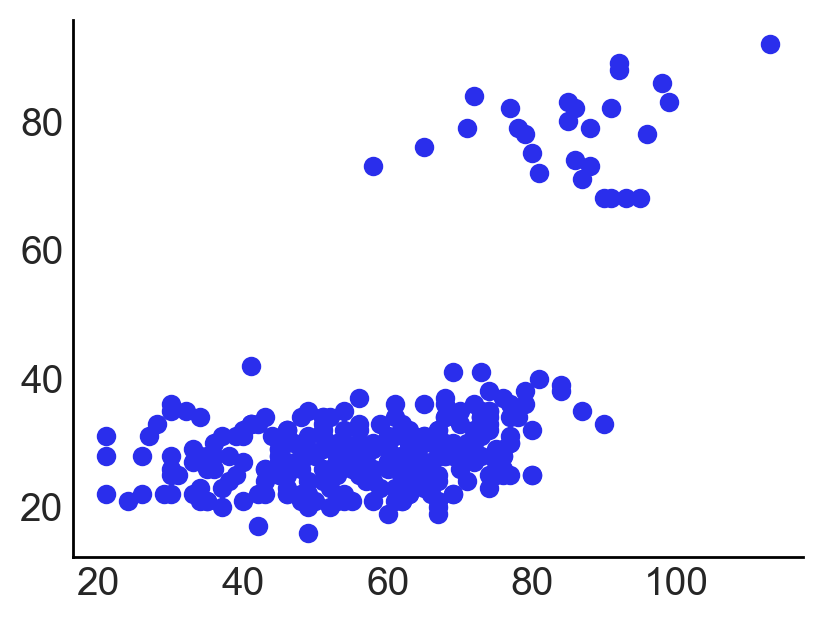

In [300]:
plt.figure(figsize=(4,3))
plt.scatter(np.sum(obs_mat,1), np.sum(mat,1))

In [301]:
trils_pd = pd.DataFrame({'true' : triu_vals, 'obs' : triu_obs})
print(pd.crosstab(index=trils_pd['true'], columns=trils_pd['obs']))


obs     0.0   1.0
true             
0.0   34729  5215
1.0    1223  3683


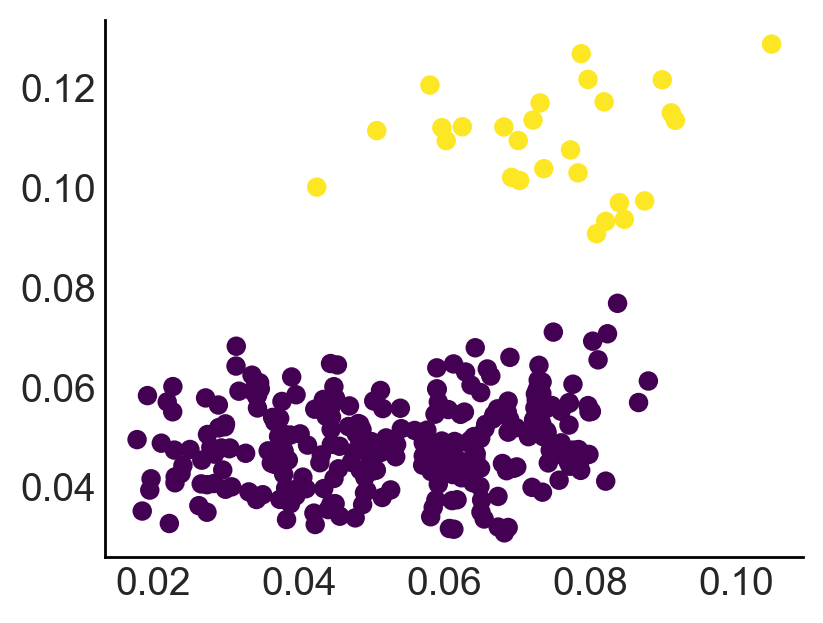

In [349]:
plt.figure(figsize=(4,3))
# plt.scatter(obs_betweeness, betweeness)
plt.scatter(obs_eigen_cen, eigen_center, c= x2)

                0
count  300.000000
mean     1.775307
std      0.614382
min      0.323438
25%      1.276412
50%      1.811490
75%      2.211871
max      3.352026
Corr obs~true exposures:  0.548700804443087
Corr obs~true Zeigen:  0.41461126057239667
Corr true_zeigen~Y :  0.47221346870525077
Corr obs_zeigen~Y :  0.11917400041925878


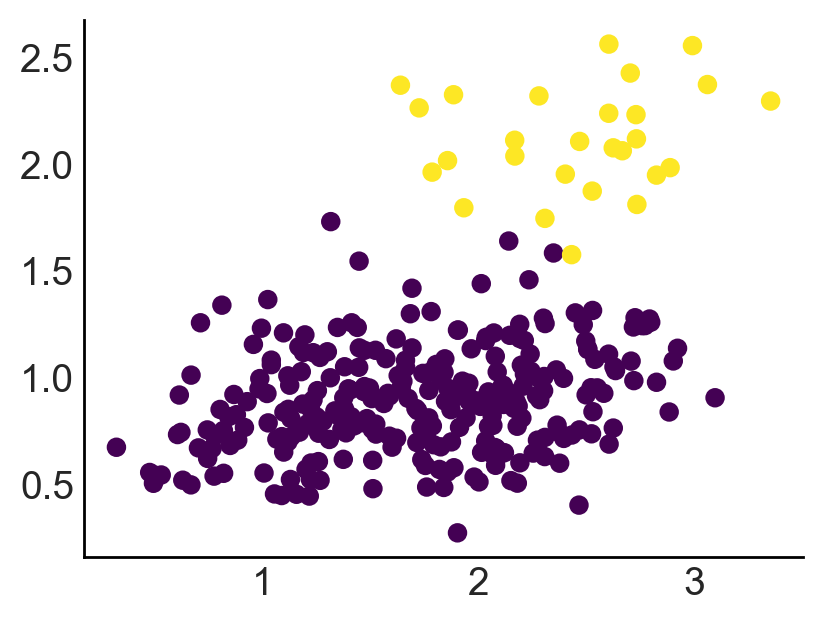

In [399]:
 
# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1) > 0.5
# # obs_exposures = np.dot(obs_mat,Z)
# obs_exposures = np.dot(obs_mat,Z)


# obs_net = nx.from_numpy_array(obs_mat)
# obs_deg = np.array([degree for _, degree in obs_net.degree()])
# obs_betweeness = np.array(list(nx.betweenness_centrality(obs_net).values()))
# obs_triangles = np.array(list(nx.triangles(obs_net).values()))
# obs_eigen_center = np.array(list(nx.eigenvector_centrality_numpy(obs_net).values()))
obs_degrees = np.sum(obs_mat,1)
obs_eigen_cent = eigen_centrality(obs_mat)
obs_exposures = np.dot(obs_mat,Z) / obs_degrees
# obs_Zeigen = np.dot(obs_mat, Z*obs_eigen_cent)
obs_Zeigen = zeigen_value(Z, obs_eigen_cent, obs_mat)

# obs_df = np.transpose(np.array([[1]*n, Z, obs_exposures,x, obs_eigen_center, obs_betweeness]))
# obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen, obs_exposures]))

# obs_df = np.transpose(np.array([[1]*n, Z, x, x2, obs_Zeigen]))
obs_df = np.transpose(np.array([[1]*n, Z, x, obs_Zeigen]))

print(pd.DataFrame(obs_Zeigen).describe())

print("Corr obs~true exposures: ", np.corrcoef(exposures, obs_exposures)[1,0])
print("Corr obs~true Zeigen: ", np.corrcoef(Zeigen, obs_Zeigen)[1,0])
print("Corr true_zeigen~Y : ", np.corrcoef(Zeigen, Y)[1,0])
print("Corr obs_zeigen~Y : ", np.corrcoef(obs_Zeigen, Y)[1,0])

# obs_exposures = np.dot(obs_mat,Z)/np.sum(obs_mat,1)
# expos_pd = pd.DataFrame({'true' : exposures, 'obs' : obs_exposures})
# pd.crosstab(index=expos_pd['true'], columns=expos_pd['obs'])
plt.figure(figsize=(4,3))
# plt.scatter(obs_exposures,exposures, c=Z)
plt.scatter(obs_Zeigen,Zeigen, c=x2)

In [352]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
data = {
    'obs_Zigen': obs_Zeigen,
    'Zeigen': Zeigen,
    'x2': x2
}
df = pd.DataFrame(data)
formula = 'obs_Zigen ~ Zeigen + x2'
# Fit the model
model = smf.ols(formula=formula, data=df).fit()
# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              obs_Zigen   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     30.84
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           6.76e-13
Time:                        17:33:30   Log-Likelihood:                -250.73
No. Observations:                 300   AIC:                             507.5
Df Residuals:                     297   BIC:                             518.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1905      0.123      9.657      0.0

In [354]:
print(np.corrcoef(obs_Zeigen, x2))
print(np.corrcoef(Zeigen, x2))

print(np.corrcoef(obs_Zeigen, x))
print(np.corrcoef(Zeigen, x))


[[1.         0.34441501]
 [0.34441501 1.        ]]
[[1.         0.81948154]
 [0.81948154 1.        ]]
[[1.         0.07134518]
 [0.07134518 1.        ]]
[[ 1.         -0.06398458]
 [-0.06398458  1.        ]]


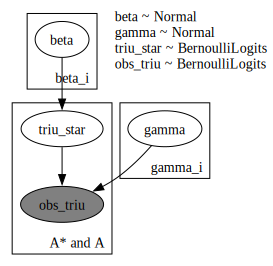

In [304]:
# NumPyro model
# def triu_to_mat(triu, n):
#     adj_mat = jnp.zeros((n,n))
#     idx_utri = np.triu_indices(n=n,k=1)
#     adj_mat = adj_mat.at[idx_utri].set(triu) 
#     return adj_mat + adj_mat.T

NN = n

@jit
def Triu_to_mat(triu_v):
    adj_mat = jnp.zeros((NN,NN))
    # idx_utri = np.triu_indices(n=NN,k=1)
    adj_mat = adj_mat.at[np.triu_indices(n=NN,k=1)].set(triu_v) 
    return adj_mat + adj_mat.T

@config_enumerate
def network_model(X, X2, TriU):
    # Network model
    # beta_0 = numpyro.sample("beta0",dist.Normal(0,10))
    # beta_1 = numpyro.sample("beta1",dist.Normal(0,10))
    with numpyro.plate("beta_i",2):
        beta = numpyro.sample("beta", dist.Normal(0,5))
    # mu_net = beta[0] + beta[1]*X + beta[2]*X2
    mu_net = beta[0] + beta[1]*X2
    # triu_n = int(n*(n-1)/2)
    
    # gamma0 = numpyro.sample("gamma0", dist.Uniform(low=0,high=0.5))
    # gamma1 = numpyro.sample("gamma1", dist.Uniform(low=0,high=0.5))
    with numpyro.plate("gamma_i",2):
        gamma = numpyro.sample("gamma", dist.Normal(0,5))
    
    # gamma0 = numpyro.sample("gamma0", dist.Beta(2,5))
    # gamma1 = numpyro.sample("gamma1", dist.Beta(2,5))
    
    with numpyro.plate("A* and A", TriU.shape[0]):
        triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_net),
                                   infer={"enumerate": "parallel"})
        # prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
        # prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*gamma0
        # prob_misspec = triu_star*(1-gamma1) + (1-triu_star)*expit(gamma[0] + gamma[1]*X + gamma[2]*X2)
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*(gamma[1] + gamma[2]*X + gamma[3]*X2)
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*(gamma[1] + gamma[2]*X2)
        # logit_misspec = jnp.where(triu_star, gamma[0], gamma[1]*X)
        logit_misspec = triu_star*gamma[0] + (1-triu_star)*gamma[1]*X
        # logit_misspec = triu_star*gamma[0] + (1-triu_star)*gamma[1]
        # numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
        numpyro.sample("obs_triu", dist.Bernoulli(logits = logit_misspec), obs = TriU)
        
    # def triu_fn(carry, inp):
    #     # print("Starting tril_fn carry no.", carry)
    #     # mu_n = inp
    #     mu_n, triu_val = inp
    #     # logp of A* 
    #     # with numpyro.plate("Edges A*", triu_n):
    #     triu_star = numpyro.sample("triu_star",dist.Bernoulli(logits=mu_n),
    #                                infer={"enumerate": "parallel"})
    #     # print("Triu_Star shape (within) is", triu_star.shape)
    #     # # logp of A|A*
    #     # # with numpyro.plate("A|A*", 1):
    #     prob_misspec = jnp.where(triu_star==1, 1-gamma1, gamma0)
    #     # print("prob_misspec shape is: ", prob_misspec.shape)
    #     # obs_triu_vals = numpyro.sample("obs_triu", dist.Bernoulli(probs = prob_misspec), obs = TriU)
    #     return carry+1, triu_star  
    # 
    # sc_input = jnp.array((mu_net, TriU)).T
    # _, triu_var = scan(triu_fn, jnp.array(0), sc_input)
    # print("triu_var shape is: ", triu_var.shape)
    # scan(triu_fn, jnp.array(0), sc_input)    
    # 


# def outcome_model(Y,Z,X,A,n):

def outcome_model(X, Y=None):
    with numpyro.plate("Lin coef.",X.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    sig = numpyro.sample("sig",dist.HalfNormal(scale=2))
    # sig = numpyro.sample("sig",dist.Exponential(0.5))
    
    # expos = jnp.dot(A,Z)
    # expos = (jnp.dot(A,Z) / jnp.sum(A,1)) > 0.5
    # sum_expos = jnp.dot(A,Z)
    # deg = jnp.sum(A,1)
    # expos = jnp.where(jnp.equal(deg,0), 0, sum_expos/deg)
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*X 
    mu_y = jnp.dot(X, alpha)
    # mu_y = numpyro.deterministic("mu", jnp.dot(X, alpha))
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*deg  + alpha[4]*X
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    # mu_y = alpha[0] + alpha[1]*Z + alpha[2]*expos + alpha[3]*expos*Z + alpha[4]*deg
    with numpyro.plate("obs",X.shape[0]):
        numpyro.sample("Y", dist.Normal(loc=mu_y,scale=sig), obs=Y)
        
        
def HSGP_model(Xlin, Xgp, ell, m, Y=None, non_centered=True):
    # --- Priors ---
    magn = numpyro.sample("magn", dist.HalfNormal(2))
    length = numpyro.sample("length", dist.HalfNormal(5))
    sig = numpyro.sample("sig", dist.HalfNormal(2))
    # --- Parametrization ---
    f = hsgp_squared_exponential(
        x=Xgp, alpha=magn, length=length, ell=ell, m=m, non_centered=non_centered
    )
    with numpyro.plate("Lin coef.",Xlin.shape[1]):
        alpha = numpyro.sample("alpha",dist.Normal(0,5))
    # mu = numpyro.deterministic("mu", jnp.dot(Xlin, alpha) + f)
    mu = jnp.dot(Xlin, alpha) + f
    # mu = beta0 + beta1*x_lin + f
    # --- Likelihood ---
    with numpyro.plate("obs", Xlin.shape[0]):
        # numpyro.sample("likelihood", dist.Normal(loc=mu, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=f, scale=noise), obs=y)
        # numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y, sample_shape=(Xgp.shape[0],))
        numpyro.sample("Y", dist.Normal(loc=mu, scale=sig), obs=Y)
        

# numpyro.render_model(model, model_args=(Y,Z,x_diff,triu_obs,n), render_distributions=True)
numpyro.render_model(network_model, model_args=(x_diff, x2_or ,triu_obs), render_distributions=True)
# numpyro.render_model(model, model_args=(Y,Z,x_diff,tril_vals))

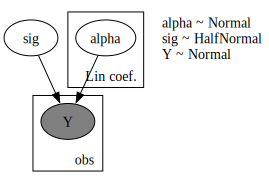

In [402]:
# numpyro.render_model(outcome_model, model_args=(Y,Z,x,mat,n), render_distributions=True)

df_array = jnp.array(df_array)
Y = jnp.array(Y)

numpyro.render_model(outcome_model, model_args=(df_array,Y), render_distributions=True)

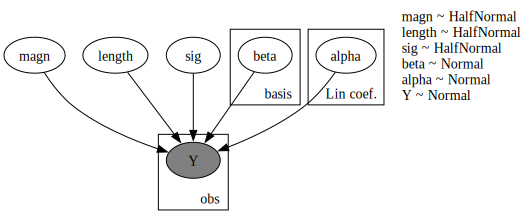

In [404]:
c = 3.5

Xgp = jnp.array(df_array[:,3:])
# Xgp = jnp.array(df_array[:,4:])
# Xlin = jnp.array(df_array[:,0:4])
Xlin = jnp.array(df_array[:,0:3])

# ell = 3.5*np.max(np.abs(df_array[:,3:]))
ell = jnp.array(c*np.max(np.abs(Xgp))).reshape(1,1)
m = 20
# m = 10
# m = 50

numpyro.render_model(HSGP_model, model_args=(Xgp, Xlin, ell, m, Y), render_distributions=True)

In [308]:
# A* and A|A* models

rng_key = random.PRNGKey(19)
rng_key, rng_key_ = random.split(rng_key)

start = time.time()
# kernel = DiscreteHMCGibbs(NUTS(model))
# kernel = MixedHMC(HMC(model, trajectory_length=1.2))  
# kernel = NUTS(model, dense_mass=True)
# kernel_network = NUTS(network_model, dense_mass=[("gamma","beta")], max_tree_depth=15)
# kernel_network = NUTS(network_model)
kernel_network = NUTS(network_model, init_strategy=numpyro.infer.init_to_median(num_samples=30))
# kernel_network = NUTS(network_model, 
                      # init_strategy=numpyro.infer.init_to_value(values={"beta": jnp.array([0.0,0.0,0.0]),"gamma" : jnp.array([0.0, 0.0])}))
mcmc_network = MCMC(kernel_network, num_warmup=1000, num_samples=1000,num_chains=4)
# mcmc_network = MCMC(kernel_network, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc.run(rng_key_,Y=Y,Z=Z,expos=obs_exposures,X=x_diff,TriL=tril_obs,n=100)
# mcmc.run(rng_key_,Y=Y,Z=Z,X=x_diff,TriU=triu_obs,n=n)
mcmc_network.run(rng_key_,X=x_diff,X2  = x2_or, TriU=triu_obs)
mcmc_network.print_summary()
samples_network = mcmc_network.get_samples()
print(time.time() - start)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]     -2.47      0.14     -2.46     -2.71     -2.27    218.02      1.00
   beta[1]      1.47      0.09      1.47      1.32      1.61     86.48      1.01
  gamma[0]      1.30      1.26      1.00      0.32      2.21    310.80      1.01
  gamma[1]     -1.00      0.02     -1.00     -1.05     -0.97    260.02      1.01

Number of divergences: 83
224.04270935058594


In [145]:
@jit
def Astar_pred(key, post_samples, Xd, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    return pred_func(key, X=Xd, TriU=triu)
        

In [ ]:
# Outcome model with A* (true network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, jit_model_args=True, chain_method="vectorized")
                         # chain_method="vectorized")
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_network_true.run(rng_key_,X=df_array,Y=Y)
mcmc_network_true.print_summary()
samples_net_true = mcmc_network_true.get_samples()
true_net_lin_predictive = Predictive(outcome_model, samples_net_true)

# print(time.time() - start)

In [ ]:
start = time.time()
mcmc_network_true.run(rng_key,X=df_array,Y=Y)
true_samps = mcmc_network_true.get_samples()
# mcmc_network_true.print_summary()
print(time.time()-start)

In [407]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)


@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    # lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=1000, num_samples=2000,num_chains=4, progress_bar=False, chain_method="vectorized")
    # lin_mcmc = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit
def outcome_jit_pred(post_samples, df_arr, key=rng_key):
    pred_func = Predictive(outcome_model, post_samples)
    return pred_func(key, df_arr)



In [408]:
start = time.time()
samples_net_true = linear_model_samples(rng_key,Y=Y, df=df_array)
print(time.time()-start)

13.433667421340942


In [410]:
print({"alpha" : jnp.expand_dims(jnp.mean(samples_net_true["alpha"],axis=0),-2)})

{'alpha': Array([[-0.9790313 ,  2.9645412 , -0.24276039,  2.5111027 ]], dtype=float32)}


In [ ]:
# Outcome model with A (observed network)

# start = time.time()
kernel_outcome = NUTS(outcome_model)
mcmc_network_obs = MCMC(kernel_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,X=x,A=obs_mat,n=n)
mcmc_network_obs.run(rng_key_, X=obs_df, Y=Y)
# mcmc_network_obs.run(rng_key_,Y=Y,Z=Z,A=mat,n=n)
mcmc_network_obs.print_summary()
samples_net_obs = mcmc_network_obs.get_samples()
obs_net_lin_predictive = Predictive(outcome_model, samples_net_obs)

# print(time.time() - start)

In [411]:
samples_net_obs = linear_model_samples(rng_key_,Y=Y, df=jnp.array(obs_df))
print({"alpha" : jnp.expand_dims(jnp.mean(samples_net_obs["alpha"],axis=0),-2)})

{'alpha': Array([[ 0.2962654,  2.7566895, -0.279298 ,  0.7550744]], dtype=float32)}


(array([   4.,   46.,  300., 1087., 2283., 2451., 1333.,  399.,   88.,
           9.]),
 array([2.07144117, 2.1730814 , 2.27472138, 2.37636161, 2.47800159,
        2.57964182, 2.68128204, 2.78292203, 2.88456225, 2.98620224,
        3.08784246]),
 <BarContainer object of 10 artists>)

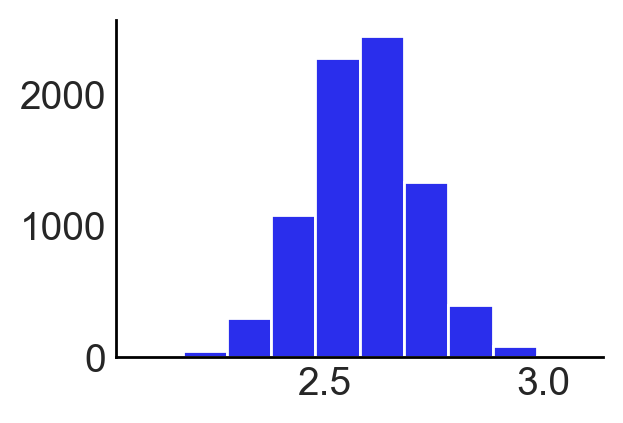

In [374]:
plt.figure(figsize=(3,2))
plt.hist(samples_net_true["alpha"][:,4])
# plt.axvline(x=alpha[4], color="red")

In [ ]:
# print([f"beta_{i} = {bet}" for i,bet in enumerate(beta)], "gamma0:", gamma0, "gamma1:", gamma1)
# print([f"alpha_{i} = {al}" for i,al in enumerate(alpha)],"sig:", 1)

In [ ]:
# start = time.time()
kernel_gp_outcome = NUTS(HSGP_model)
mcmc_GP_network_true = MCMC(kernel_gp_outcome, num_warmup=2000, num_samples=4000,num_chains=4)
# mcmc_network_true = MCMC(kernel_outcome, num_warmup=100, num_samples=10,num_chains=1)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,A=obs_mat,n=n)
# mcmc_network_true.run(rng_key_,Y=Y,Z=Z,X=x,A=mat,n=n)
mcmc_GP_network_true.run(rng_key_,Xgp=Xgp, Xlin=Xlin, ell=ell ,m=m, Y=Y)
# mcmc_GP_network_true.run(rng_key_,Xgp=Zeigen, Xlin=Xlin, Y=Y, ell=ell ,m=m)
mcmc_GP_network_true.print_summary()
samples_GP_net_true = mcmc_GP_network_true.get_samples()
# print(time.time() - start)
HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)


In [412]:
M = m
num_warmup=1000
# num_warmup=2000
# num_warmup=250
# num_samples=25
num_samples=2000
# num_samples=4000
num_chains=4

@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def HSGP_jit_pred(post_samples, Xgp, Xlin, ell):
    pred_func = Predictive(HSGP_model, post_samples)
    return pred_func(rng_key, Xgp=Xgp, Xlin = Xlin, ell=ell, m=M)




In [413]:

samples_GP_net_true = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp, Xlin=Xlin, ell=ell)
# HSGP_true_predictive = Predictive(HSGP_model, samples_GP_net_true)


In [414]:
# HSGP with noisy data
Xlin_obs = jnp.array(obs_df[:,0:3])
# Xlin_obs = jnp.array(obs_df[:,0:4])
Xgp_obs = jnp.array(obs_df[:,3:])
# Xgp_obs = jnp.array(obs_df[:,4:])
ell_obs = jnp.array(c*jnp.max(jnp.abs(Xgp_obs))).reshape(1,1)

In [415]:

samples_GP_net_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=Xgp_obs, Xlin=Xlin_obs, ell=ell_obs)
# mcmc_GP_network_obs = HSGP_model_samples(rng_key_,Y=Y, Xgp=jnp.array(Xgp_obs), Xlin=jnp.array(Xlin_obs), ell=jnp.array(ell_obs).reshape(1,1))
# HSGP_obs_predictive = Predictive(HSGP_model, samples_GP_net_obs)



In [417]:
# h_x = ((x > 1.5) | (x < -1.5)).astype(int)
# h_x2 = ((x > 2) | (x < 2)).astype(int)

def Dynamic_intervention(x, threshold = 1.5):
    return np.where((x > threshold) | (x < -threshold), 1, 0)
    # return ((x > threshold) | (x < threshold)).astype(int)

def Stochastic_interention(alph, n_approx = 1e4):
    return rng.binomial(n=1, p=alph, size=(n_approx,n))
# 
# # h_x = np.array([1]*n)
# h_x = rng.binomial(n=1,p=0.6,size=n)
# h_x2 = rng.binomial(n=1,p=0.2,size=n)

# h_1 = np.where(((x >= -1) & (x <= 1)) | (x2 == 1), 1, 0)
# h_2 = np.where(x2 == 1, 1, 0)
# h_1 = Dynamic_intervention(x)
h_1 = Dynamic_intervention(x)
h_2 = Dynamic_intervention(x, threshold=2)
Z_stoch = Stochastic_interention(alph=0.7, n_approx=100)
Z_stoch2 = Stochastic_interention(alph=0.3, n_approx=100)
Z_all = np.array([1]*n)
Z_none = np.array([0]*n)

h_zeigen = zeigen_value(h_1, eigen_center, mat)
h2_zeigen = zeigen_value(h_2, eigen_center, mat)
h_zeigen_obs = zeigen_value(h_1, obs_eigen_cent, obs_mat)

Stoch_zeigen = zeigen_value(Z_stoch, eigen_center, mat)
Stoch_zeigen2 = zeigen_value(Z_stoch2, eigen_center, mat)

all_zeigen = zeigen_value(Z_all, eigen_center, mat)
none_zeigen = zeigen_value(Z_none, eigen_center, mat)

print(h_1.shape)
print(h_zeigen.shape)
print(Z_stoch.shape)
print(Z_stoch[0,].shape)
print(Z_stoch[0].shape)
print(Stoch_zeigen.shape)
# print(np.mean(Stoch_zeigen,axis=1))

(300,)
(300,)
(100, 300)
(300,)
(300,)
(100, 300)


3.739424167178222


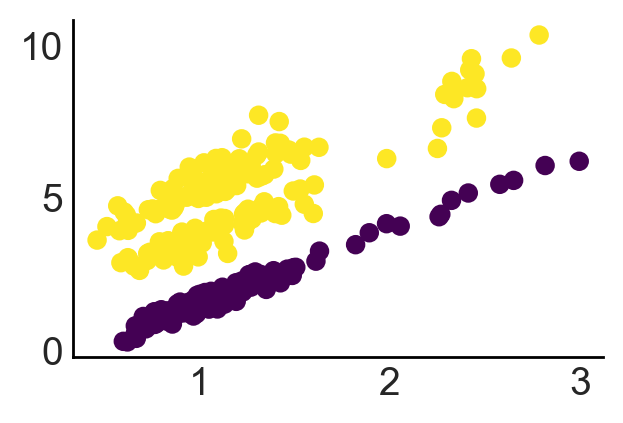

In [418]:
X_h_true = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen]))
X_h_obs = jnp.transpose(jnp.array([[1]*n, h_1, x, h_zeigen_obs]))
# X_h_true = jnp.transpose(jnp.array([[1]*n, h_1, x, x2, h_zeigen]))
# X_h_obs = jnp.transpose(jnp.array([[1]*n, h_1, x, x2, h_zeigen_obs]))

ell_h = jnp.array(c*jnp.max(jnp.abs(h_zeigen))).reshape(1,1)
ell_h_obs = jnp.array(c*jnp.max(jnp.abs(h_zeigen_obs))).reshape(1,1)

# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=False)
# Y_test,epsi_test = gen_y(X_h_true[:,0:3], h_zeigen, alpha, lin=True)
Y_test, epsi_test = gen_y(X_h_true[:,0:4], h_zeigen, alpha, lin=True)
# Y_test2,_ = gen_y(X_test_true2[:,0:3], true_h_x_eigen2,alpha,lin=False)

mu_test = Y_test - epsi_test
true_estimand = np.mean(mu_test)
print(true_estimand)
# true_ce = Y_test - Y_test2

plt.figure(figsize=(3,2))
plt.scatter(h_zeigen,mu_test, c=h_1)
# plt.scatter(mean_y,mu_test, c =h_x)

In [419]:
# @jit
def get_true_estimand(z_new, zeigen_new , x,x2, alpha, lin=True):
    n = x.shape[0]
    if z_new.ndim == 2:
        n_stoch = z_new.shape[0]
        results = np.zeros((n_stoch,1))
        for i in range(n_stoch):
            df = np.transpose(jnp.array([[1]*n, z_new[i,], x, x2]))
            y, epsi = gen_y(df, zeigen_new[i,], alpha, lin=lin)
            results[i,] = np.mean(y-epsi)
        return np.mean(results, axis=0).squeeze()
    else:
        # assert Z_stoch.ndim == 1
        df = np.transpose(jnp.array([[1]*n, z_new, x, x2]))
        y, epsi = gen_y(df, zeigen_new, alpha, lin=lin)
        return np.mean(y-epsi)
    
stoch_estimand = get_true_estimand(Z_stoch, Stoch_zeigen, x,x2, alpha, True)
print(stoch_estimand)

4.807103363685954


In [420]:
hestimand = get_true_estimand(h_1, h_zeigen, x, x2, alpha, True)
print(hestimand)

3.739424167178222


In [421]:
all_esti = get_true_estimand(Z_all, all_zeigen, x,x2,  alpha, True)
none_esti = get_true_estimand(Z_none, none_zeigen, x,x2,  alpha, True)
gte = all_esti - none_esti
print(all_esti, none_esti, gte)


7.263838256549983 -0.901102043040446 8.164940299590429


In [422]:
h1_esti = get_true_estimand(h_1, h_zeigen, x,x2,  alpha, True)
h2_esti = get_true_estimand(h_2, h2_zeigen, x, x2, alpha, True)
hte = h1_esti - h2_esti
print(h1_esti, h2_esti, hte)

3.739424167178222 2.9427705131989206 0.7966536539793014


In [423]:
stoch_esti = get_true_estimand(Z_stoch, Stoch_zeigen, x,x2,  alpha, True)
stoch_esti2 = get_true_estimand(Z_stoch2, Stoch_zeigen2, x,x2,  alpha, True)
te_stoch = stoch_esti - stoch_esti2
print(stoch_esti, stoch_esti2, te_stoch)

4.807103363685954 1.505999068517323 3.301104295168631


In [424]:
def compute_error_stats(esti_post_draws, true_estimand, method="TEST", idx=None):
    mean = np.round(np.mean(esti_post_draws),3) 
    medi = np.round(np.median(esti_post_draws),3) 
    std = np.round(np.std(esti_post_draws),3)
    RMSE = np.round(np.sqrt(np.mean(np.power(esti_post_draws - true_estimand, 2))),3)
    MAE = np.round(np.mean(np.abs(esti_post_draws - true_estimand)),3)
    MAPE = np.round(np.mean(np.abs(esti_post_draws - true_estimand)/np.abs(true_estimand)),3)
    q025 = np.quantile(esti_post_draws, 0.025)
    q975 = np.quantile(esti_post_draws, 0.975)
    cover = q025 <= true_estimand <= q975
    return pd.DataFrame([{"idx" : idx, "method" : method,
            "mean" : mean, "median" : medi, "true" : np.round(true_estimand,3), 
            "bias" : np.round(mean - true_estimand,3), "std" : std, "RMSE" : RMSE,
            "MAE" : MAE, "MAPE" : MAPE,
            "q025" : np.round(q025,3), "q975" : np.round(q975,3), "covering" : cover}])


In [425]:
print(Z_stoch.ndim, h_1.ndim, h_1.shape[0], h_1.reshape((1, h_1.shape[0])).shape)

2 1 300 (1, 300)


In [427]:
@jit
def linear_model_outcome_pred(z, zeigen, post_samples, x, x2):
    # df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, x2, zeigen]))
    df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, zeigen]))
    pred = outcome_jit_pred(post_samples, df)
    return jnp.mean(pred["Y"], axis=1)

linear_model_pred = jax.vmap(linear_model_outcome_pred, in_axes= (0, 0, None, None, None))

def linear_pred(z, zeigen, post_samples, x,x2):
    if z.ndim == 2:
        return linear_model_pred(z, zeigen, post_samples, x, x2)
        # return linear_model_pred(z, zeigen, post_samples, x)
    if z.ndim == 1:
        n_z = z.shape[0]
        return linear_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x,x2)
        # return linear_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x)
        
@jit
def hsgp_model_outcome_pred(z, zeigen, post_samples, x, x2, ell):
    # ell_ = jnp.array(c*jnp.max(jnp.abs(zeigen))).reshape(1,1)
    # df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, x2, zeigen]))
    df = jnp.transpose(jnp.array([[1]*x.shape[0], z, x, zeigen]))
    # pred = HSGP_jit_pred(post_samples, Xgp=df[:,4:], Xlin = df[:,0:4], ell=ell)
    pred = HSGP_jit_pred(post_samples, Xgp=df[:,3:], Xlin = df[:,0:3], ell=ell)
    return jnp.mean(pred["Y"], axis=1)

hsgp_model_pred = jax.vmap(hsgp_model_outcome_pred, in_axes= (0, 0, None, None, None, None))

def hsgp_pred(z, zeigen, post_samples, x, x2, ell):
    if z.ndim == 2:
        return hsgp_model_pred(z, zeigen, post_samples, x,x2,  ell)
    if z.ndim == 1:
        n_z = z.shape[0]
        return hsgp_model_pred(z.reshape((1,n_z)), zeigen.reshape((1,n_z)), post_samples, x,x2,  ell)
        

In [428]:
# GTE
lin_all_pred = linear_pred(Z_all, all_zeigen, samples_net_true, x, x2)
lin_none_pred = linear_pred(Z_none, none_zeigen, samples_net_true, x, x2)
# lin_gte_pred = jnp.mean(lin_all_pred,axis=0) - jnp.mean(lin_none_pred, axis=0)
lin_gte_pred = jnp.mean(lin_all_pred - lin_none_pred,axis=0) 
print(compute_error_stats(lin_gte_pred, gte))

    idx method   mean  median   true    bias    std   RMSE    MAE   MAPE  \
0  None   TEST  8.152   8.153  8.165  -0.013  0.155  0.155  0.124  0.015   

   q025   q975  covering  
0  7.85  8.458      True  


In [429]:
# GTE HSGP
hsgp_all_pred = hsgp_pred(Z_all, all_zeigen, samples_GP_net_true, x, x2, ell)   
hsgp_none_pred = hsgp_pred(Z_none, none_zeigen, samples_GP_net_true, x,x2,  ell)
# hsgp_gte_pred = jnp.mean(hsgp_all_pred,axis=0) - jnp.mean(hsgp_none_pred, axis=0)
hsgp_gte_pred = jnp.mean(hsgp_all_pred - hsgp_none_pred,axis=0)
print(compute_error_stats(hsgp_gte_pred, gte))

    idx method       mean  median   true   bias         std   RMSE    MAE  \
0  None   TEST  7.3050003   7.411  8.165  -0.86  0.56200004  1.027  0.867   

    MAPE   q025  q975  covering  
0  0.106  6.026  8.16     False  


In [430]:
# HTE
lin_h1_pred = linear_pred(h_1, h_zeigen, samples_net_true, x,x2)
lin_h2_pred = linear_pred(h_2, h2_zeigen, samples_net_true, x, x2)
lin_hte_pred = jnp.mean(lin_h1_pred,axis=0) - jnp.mean(lin_h2_pred, axis=0)
print(compute_error_stats(lin_hte_pred, hte))

    idx method        mean  median   true    bias          std   RMSE    MAE  \
0  None   TEST  0.79600006   0.796  0.797  -0.001  0.015000001  0.015  0.012   

    MAPE   q025   q975  covering  
0  0.015  0.766  0.826      True  


In [431]:
# HTE HSGP
hsgp_h1_pred = hsgp_pred(h_1, h_zeigen, samples_GP_net_true, x, x2, ell)
hsgp_h2_pred = hsgp_pred(h_2, h2_zeigen, samples_GP_net_true, x,x2,  ell)
hsgp_hte_pred = jnp.mean(hsgp_h1_pred,axis=0) - jnp.mean(hsgp_h2_pred, axis=0)
print(compute_error_stats(hsgp_hte_pred, hte))


    idx method mean  median   true   bias          std   RMSE    MAE   MAPE  \
0  None   TEST  0.8     0.8  0.797  0.003  0.021000002  0.022  0.017  0.021   

    q025   q975  covering  
0  0.758  0.843      True  


In [432]:
# HTE Obs
lin_h1_pred_obs = linear_pred(h_1, h_zeigen, samples_net_obs, x, x2)
lin_h2_pred_obs = linear_pred(h_2, h2_zeigen, samples_net_obs, x, x2)
lin_hte_pred_obs = jnp.mean(lin_h1_pred_obs,axis=0) - jnp.mean(lin_h2_pred_obs, axis=0)
print(compute_error_stats(lin_hte_pred_obs, hte))


    idx method        mean  median   true    bias    std   RMSE    MAE   MAPE  \
0  None   TEST  0.41300002   0.414  0.797  -0.384  0.025  0.384  0.383  0.481   

    q025   q975  covering  
0  0.364  0.463     False  


In [433]:
# HTE HSGP Obs
hsgp_h1_pred_obs = hsgp_pred(h_1, h_zeigen, samples_GP_net_obs, x, x2, ell_obs)
hsgp_h2_pred_obs = hsgp_pred(h_2, h2_zeigen, samples_GP_net_obs, x, x2, ell_obs)
hsgp_hte_pred_obs = jnp.mean(hsgp_h1_pred_obs,axis=0) - jnp.mean(hsgp_h2_pred_obs, axis=0)
print(compute_error_stats(hsgp_hte_pred_obs, hte))

    idx method   mean  median   true    bias    std   RMSE    MAE   MAPE  \
0  None   TEST  0.423   0.422  0.797  -0.374  0.063  0.379  0.374  0.469   

    q025   q975  covering  
0  0.307  0.549     False  


In [434]:
# Stochastic TE
lin_stoch_pred = linear_pred(Z_stoch, Stoch_zeigen, samples_net_true, x, x2)
lin_stoch_pred2 = linear_pred(Z_stoch2, Stoch_zeigen2, samples_net_true, x, x2)
lin_te_stoch_pred = jnp.mean(lin_stoch_pred,axis=0) - jnp.mean(lin_stoch_pred2, axis=0)
print(compute_error_stats(lin_te_stoch_pred, te_stoch))

    idx method       mean  median   true           bias    std   RMSE   MAE  \
0  None   TEST  3.2960002   3.296  3.301  -0.0050000004  0.063  0.063  0.05   

    MAPE   q025  q975  covering  
0  0.015  3.174  3.42      True  


In [435]:
# Stochastic TE HSGP
hsgp_stoch_pred = hsgp_pred(Z_stoch, Stoch_zeigen, samples_GP_net_true, x,x2,  ell)
hsgp_stoch_pred2 = hsgp_pred(Z_stoch2, Stoch_zeigen2, samples_GP_net_true, x,x2,  ell)
hsgp_te_stoch_pred = jnp.mean(hsgp_stoch_pred,axis=0) - jnp.mean(hsgp_stoch_pred2, axis=0)
print(compute_error_stats(hsgp_te_stoch_pred, te_stoch))


    idx method   mean  median   true          bias          std   RMSE   MAE  \
0  None   TEST  3.242   3.246  3.301  -0.059000004  0.098000005  0.115  0.09   

    MAPE   q025   q975  covering  
0  0.027  3.036  3.423      True  


In [436]:
# Stochastic TE obs
lin_stoch_pred_obs = linear_pred(Z_stoch, Stoch_zeigen, samples_net_obs, x,x2)
lin_stoch_pred2_obs = linear_pred(Z_stoch2, Stoch_zeigen2, samples_net_obs, x, x2)
lin_te_stoch_pred_obs = jnp.mean(lin_stoch_pred_obs,axis=0) - jnp.mean(lin_stoch_pred2_obs, axis=0)
print(compute_error_stats(lin_te_stoch_pred_obs, te_stoch))

    idx method   mean  median   true        bias    std   RMSE    MAE   MAPE  \
0  None   TEST  1.743   1.745  3.301  -1.5580001  0.104  1.562  1.558  0.472   

    q025   q975  covering  
0  1.539  1.945     False  


In [437]:
# Stochastic TE HSGP obs
hsgp_stoch_pred_obs = hsgp_pred(Z_stoch, Stoch_zeigen, samples_GP_net_obs, x, x2, ell_obs)
hsgp_stoch_pred2_obs = hsgp_pred(Z_stoch2, Stoch_zeigen2, samples_GP_net_obs, x, x2, ell_obs)
hsgp_te_stoch_pred_obs = jnp.mean(hsgp_stoch_pred_obs,axis=0) - jnp.mean(hsgp_stoch_pred2_obs, axis=0)
print(compute_error_stats(hsgp_te_stoch_pred_obs, te_stoch))

    idx method       mean  median   true    bias         std   RMSE    MAE  \
0  None   TEST  1.7720001   1.765  3.301  -1.529  0.26200002  1.551  1.529   

    MAPE   q025   q975  covering  
0  0.463  1.283  2.294     False  


In [ ]:
lin_zstoch_pred = linear_pred(Z_stoch, Stoch_zeigen, samples_net_true, x)
print(lin_zstoch_pred.shape)
print(jnp.mean(lin_zstoch_pred, axis=0).shape)

In [ ]:
print(compute_error_stats(jnp.mean(lin_zstoch_pred, axis=0), stoch_estimand))

In [ ]:
hsgp_zstoch_pred = hsgp_pred(Z_stoch, Stoch_zeigen, samples_GP_net_true, x, ell)
print(hsgp_zstoch_pred.shape)
print(jnp.mean(hsgp_zstoch_pred, axis=0).shape)

In [ ]:
print(compute_error_stats(jnp.mean(hsgp_zstoch_pred, axis=0), stoch_estimand))

In [ ]:
lin_h_1_pred = linear_pred(h_1, h_zeigen, samples_net_true, x)
print(lin_h_1_pred.shape)
print(jnp.mean(lin_h_1_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(lin_h_1_pred, axis=0), hestimand))


In [ ]:
hsgp_h_1_pred = hsgp_pred(h_1, h_zeigen, samples_GP_net_true, x, ell)
print(hsgp_zstoch_pred.shape)
print(jnp.mean(hsgp_zstoch_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(hsgp_h_1_pred, axis=0), hestimand))

In [ ]:
# post_pred_true_net = true_net_lin_predictive(rng_key, X=X_h_true)
post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
# post_pred_true_net = outcome_jit_pred(samples_net_true, X_h_true)
print(post_pred_true_net["Y"].shape)
# print(post_pred_true_net["mu"].shape)
# post_pred_true_net2 = true_net_lin_predictive(rng_key, X=X_test_true2)
# lin_pred_true_net = np.mean(post_pred_true_net["mu"],axis=0)
lin_pred_true_net = np.mean(post_pred_true_net["Y"],axis=0)
# lin_pred_true_net_it = np.mean(post_pred_true_net["mu"],axis=1)
lin_pred_true_net_it = np.mean(post_pred_true_net["Y"],axis=1)
print(lin_pred_true_net_it.shape)

lin_pred_true_stats = compute_error_stats(lin_pred_true_net_it, hestimand)
print(lin_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_true_net,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
# post_pred_obs = outcome_jit_pred(samples_net_obs, X_h_obs)
lin_pred_obs = np.mean(post_pred_obs["Y"],axis=0)
lin_pred_obs_it = np.mean(post_pred_obs["Y"],axis=1)
print(lin_pred_obs.shape, lin_pred_obs_it.shape)

lin_pred_obs_stats = compute_error_stats(np.mean(post_pred_obs["Y"],axis=1), hestimand)
print(lin_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=lin_pred_obs,y=mu_test, c=h_1)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=M)
HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true, Xgp=X_h_true[:,4:], Xlin = X_h_true[:,0:4],ell=ell)
# HSGP_posterior_predictive = HSGP_true_predictive(rng_key, Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive["Y"].shape)
post_mu = np.mean(HSGP_posterior_predictive["Y"],axis=0)
post_mu_iter = np.mean(HSGP_posterior_predictive["Y"],axis=1)

hsgp_pred_true_stats = compute_error_stats(post_mu_iter, hestimand)
print(hsgp_pred_true_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)

In [ ]:
HSGP_posterior_predictive_obs = HSGP_jit_pred(samples_GP_net_obs, Xgp=X_h_obs[:,4:], Xlin = X_h_obs[:,0:4],ell=ell_obs)
# HSGP_posterior_predictive_obs = HSGP_obs_predictive(rng_key, Xgp=X_h_obs[:,3:], Xlin = X_h_obs[:,0:3], ell=ell_obs, m=M)
# HSGP_posterior_predictive = HSGP_jit_pred(samples_GP_net_true,Xgp=X_h_true[:,3:], Xlin = X_h_true[:,0:3],ell=ell, m=m)
print(HSGP_posterior_predictive_obs["Y"].shape)
obs_post_mu = np.mean(HSGP_posterior_predictive_obs["Y"],axis=0)
obs_post_mu_iter = np.mean(HSGP_posterior_predictive_obs["Y"],axis=1)

hsgp_pred_obs_stats = compute_error_stats(np.mean(HSGP_posterior_predictive_obs["Y"],axis=1), hestimand)
print(hsgp_pred_obs_stats)

plt.figure(figsize=(3,2))
plt.scatter(x=obs_post_mu,y=mu_test, c=h_1)
# plt.scatter(x=post_mu2,y=mu_test2, c=true_h_x_eigen2)
plt.axline((0,0),slope=1,ls="--",alpha=0.8,lw=1.3)


In [ ]:
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
print(post_pred_mean)

In [ ]:
print(samples_network["beta"].shape)
print(samples_network["gamma0"].shape)
post_pred_mean = {"beta" : jnp.expand_dims(jnp.mean(samples_network["beta"],axis=0),-2),
                  "gamma0" : jnp.expand_dims(jnp.mean(samples_network["gamma0"]),-1),
                  "gamma1" : jnp.expand_dims(jnp.mean(samples_network["gamma1"]),-1)}
# print(jnp.array(post_pred_mean))
# The following is how to sample multiple different A* with the mean posterior of A* and A|A* parameters
# a_star_pred1 = a_star_pred(random.PRNGKey(0), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=samples_network, Xd=x_diff,triu=triu_obs)
a_star_pred1 = Astar_pred(random.PRNGKey(0),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
a_star_pred2 = Astar_pred(random.PRNGKey(3),post_samples=post_pred_mean, Xd=x_diff,triu=triu_obs)
# a_star_pred2 = Astar_pred(random.PRNGKey(),post_samples=jnp.array(post_pred_mean), Xd=x_diff,triu=triu_obs, mean_post=True)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# a_star_pred2 = a_star_pred(random.PRNGKey(1), X=x_diff,TriU=triu_obs,n=n)
# print(a_star_pred)
# print(a_star_pred1["triu_star"])
print(a_star_pred1["triu_star"].shape)
print(a_star_pred1["triu_star"][0].shape)
print(a_star_pred2["triu_star"].shape)
print(jnp.array_equal(a_star_pred1["triu_star"],a_star_pred2["triu_star"]))

twoAst = pd.DataFrame({'first' : a_star_pred1["triu_star"][1], 'sec' : a_star_pred2["triu_star"][1]})
# print(twoAst)
pd.crosstab(index=twoAst['first'], columns=twoAst['sec'])

In [331]:
post_predictive = Predictive(network_model, samples_network, infer_discrete=True)
# post_predictive = post_predictive(rng_key, X=x_diff, X2=x2_equal, TriU=triu_obs)
post_predictive = post_predictive(rng_key, X=x_diff, X2=x2_or, TriU=triu_obs)
# samples_network["triu_star"] = post_predictive["triu_star"]
# print(post_predictive["triu_star"])
print(post_predictive["triu_star"].shape)
print(post_predictive["triu_star"][0,].shape)

(4000, 44850)
(44850,)


MS zeigen MAPE: 0.26316294
Obs zeigen MAPE: 0.9751394


(array([ 718., 1732.,  783.,  382.,  237.,   87.,   37.,   12.,    9.,
           3.]),
 array([0.19892891, 0.23013851, 0.26134813, 0.29255772, 0.32376733,
        0.35497692, 0.38618654, 0.41739613, 0.44860575, 0.47981533,
        0.51102495]),
 <BarContainer object of 10 artists>)

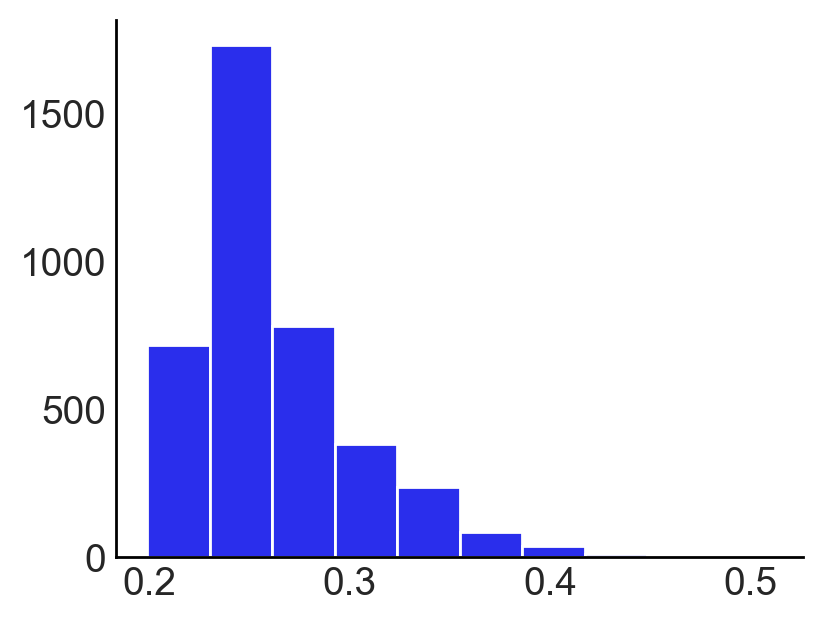

In [335]:

def get_mape_zeig(triu):
    mat = Triu_to_mat(triu)
    eig_cen = eigen_centrality(mat)
    zeig = zeigen_value(Z, eig_cen, mat)
    return jnp.mean(jnp.abs(zeig - Zeigen)/jnp.abs(Zeigen))

vm_mape_zeig = vmap(get_mape_zeig, in_axes=(0))

MS_zeig = vm_mape_zeig(post_predictive["triu_star"])

print("MS zeigen MAPE:", jnp.mean(MS_zeig))
print("Obs zeigen MAPE:", jnp.mean(jnp.abs(obs_Zeigen - Zeigen)/jnp.abs(Zeigen)))

plt.figure(figsize=(4,3))
plt.hist(MS_zeig)
      

[[1.         0.79562618]
 [0.79562618 1.        ]]
[[1.         0.41461126]
 [0.41461126 1.        ]]


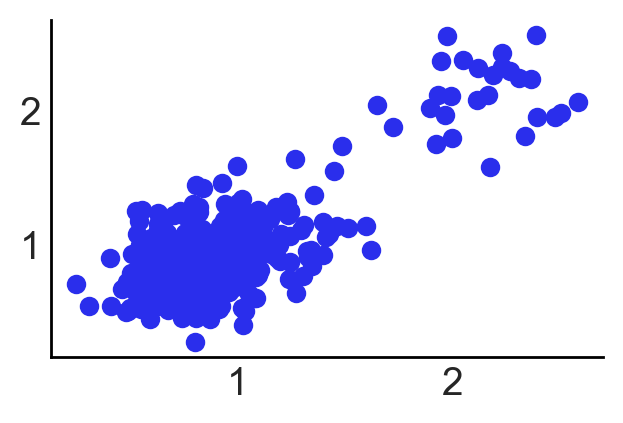

In [339]:
rand_mat = Triu_to_mat(post_predictive["triu_star"][77,])
rand_eig_cen = eigen_centrality(rand_mat)
rand_zeigen = zeigen_value(Z, rand_eig_cen, rand_mat)

plt.figure(figsize=(3,2))
plt.scatter(rand_zeigen, Zeigen)
print(np.corrcoef(rand_zeigen, Zeigen))
print(np.corrcoef(obs_Zeigen, Zeigen))

In [438]:
# rand_df = np.transpose(np.array([[1]*n, Z, x, x2, rand_zeigen]))
rand_df = np.transpose(np.array([[1]*n, Z, x, rand_zeigen]))
rand_samples_net = linear_model_samples(rng_key,Y=Y, df=rand_df)


In [440]:
# print rand_samples_net posterior mean by item
rand_post_mean = {"alpha" : jnp.expand_dims(jnp.mean(rand_samples_net["alpha"],axis=0),-2)}
rand_post_mean

{'alpha': Array([[-0.26619947,  2.7983382 , -0.2694783 ,  1.9026712 ]], dtype=float32)}

In [447]:
# NN = n

n_warmup = 500
n_samples = 100
n_chains = 1
# M = m

@jit
def linear_model_sampless(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()

@jit    
def HSGP_model_sampless(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

@jit
def compute_net_stats(Astar, Z):
    cur_eigen_cen = eigen_centrality(Astar)
    cur_Zeigen = zeigen_value(Z, cur_eigen_cen, Astar)
    # if return_ell:
    cur_ell = c*jnp.max(jnp.abs(cur_Zeigen))
        # cur_ell = jnp.array(cur_ell)[..., None]
    cur_ell = jnp.array(cur_ell).reshape(1,1)
    return cur_Zeigen, cur_ell
    # else:
    #     return cur_Zeigen
    
@jit    
def get_samples_new_Astar(Y, Z, X, X2, curr_Astar):
        cur_Zeigen, ell = compute_net_stats(curr_Astar, Z)
        # get df
        cur_df = jnp.transpose(jnp.array([[1]*NN, Z, X, cur_Zeigen]))
        # cur_df = jnp.transpose(jnp.array([[1]*NN, Z, X, X2, cur_Zeigen]))
        # Run MCMC
        cur_lin_samples = linear_model_sampless(rng_key_, Y, cur_df)
        cur_hsgp_samples = HSGP_model_sampless(rng_key_, Y=Y, Xgp=cur_df[:,3:],
                                                    Xlin=cur_df[:,0:3], ell=ell)
        # cur_hsgp_samples = HSGP_model_sampless(rng_key_, Y=Y, Xgp=cur_df[:,4:],
        #                                             Xlin=cur_df[:,0:4], ell=ell)
        # cur_hsgp_predictive = Predictive(HSGP_model, HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell))
        # cur_hsgp_predictive = HSGP_model_samples(key, Y=Y, Xgp=cur_df[:,3:],
        #                                     Xlin=cur_df[:,0:3], ell=ell)
                                                 # m=jnp.array(m).reshape(1,1))
        return cur_lin_samples, cur_hsgp_samples, ell 
        # return cur_lin_samples, cur_hsgp_samples, cur_df, ell 
        # return cur_lin_samples, cur_hsgp_predictive, cur_df, ell 

@jit        
def get_predicted_values(z, zeigen, x, x2, lin_samples, hsgp_samples, ell):
        # get predicted values 
        # each has shape (#lin_samples, n)
        cur_lin_pred = linear_pred(z, zeigen, lin_samples, x, x2)
        cur_hsgp_pred = hsgp_pred(z, zeigen, hsgp_samples, x, x2, ell)
        # cur_lin_pred = outcome_jit_pred(lin_samples, curr_df, key)
        # cur_hsgp_pred = HSGP_jit_pred(hsgp_samples,Xgp=curr_df[:,3:], Xlin = curr_df[:,0:3],ell=ell)
        # cur_hsgp_pred = hsgp_pred(key, Xgp=curr_df[:,3:], Xlin=curr_df[:,0:3],
        #                                     ell=ell, m=M)
                                            # m=m)
        # get estimands for each sample (sample mean across units)
        # lin_estimates = jnp.mean(cur_lin_pred["Y"],axis=1)
        lin_estimates =  jnp.mean(cur_lin_pred, axis=0)
        # hsgp_estimates = jnp.mean(cur_hsgp_pred["Y"],axis=1)
        hsgp_estimates = jnp.mean(cur_hsgp_pred,axis=0)
        return lin_estimates, hsgp_estimates
               
@jit
def multistage_mcmc(samp_net, Y, Z_obs, Z_new, X, X2):
    # cur_key = random.PRNGKey(i)
    # sample network
    # curr_triu_star = Astar_pred(cur_key, post_samples=post_mean, Xd=x_diff,triu=triu_obs)
    # curr_Astar = Triu_to_mat(curr_triu_star["triu_star"][0])
    curr_Astar = Triu_to_mat(samp_net)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_samples, cur_ell = get_samples_new_Astar(Y, Z_obs, X, X2, curr_Astar)
    # curr_lin_samples, curr_hsgp_samples, cur_df, cur_ell = get_samples_new_Astar(rng_key_, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    zeigen_new, _ = compute_net_stats(curr_Astar, Z_new)
    # get predicted estimands for new `Z' values
    # if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        # new_df = cur_df.at[:,1].set(Z_new)
    lin_estimates, hsgp_estimates = get_predicted_values(Z_new, zeigen_new, x, x2, curr_lin_samples, curr_hsgp_samples, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
    return jnp.array([lin_estimates, hsgp_estimates])
    # if Z_new.ndim == 2:
    #     n_iter = Z_new.shape[0]
    #     lin_results = []
    #     hsgp_results = []
    #     for j in range(n_iter):
    #         new_df = np.copy(cur_df)
    #         new_df[:,1] = Z_new[j]
    #         lin_estimates, hsgp_estimates = get_predicted_values(rng_key_, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, M)
    #         lin_results.append([lin_estimates])
    #         hsgp_results.append([hsgp_estimates])
    #         return np.array(lin_results), np.array(hsgp_results)
     

@jit
def Astar_pred(i, post_samples, Xd, X2, triu):
    # if mean_post:
    pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True,num_samples=1)
    # else:
    #     pred_func = Predictive(model=network_model, posterior_samples=post_samples, infer_discrete=True)
    samp_net = pred_func(random.PRNGKey(i**2), X=Xd, X2=X2, TriU=triu)["triu_star"]
    return jnp.squeeze(samp_net, axis=0)     
     
     
vectorized_astar_pred = jax.vmap(Astar_pred, in_axes=(0, None, None, None, None))
vectorized_multistage = jax.vmap(multistage_mcmc, in_axes=(0, None, None, None, None, None))
parallel_multistage = jax.pmap(multistage_mcmc, in_axes=(0, None, None, None, None, None))



#      
# start = time.time()
# # twostage_post_samp_jit = pd.DataFrame()
# twostage_linear = []
# twostage_hsgp = []
# # for i in tqdm(range(50)):
# for i in tqdm(range(3)):
#     cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i)
#     # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
#     twostage_linear.append(cur_lin)
#     twostage_hsgp.append(cur_hsgp)
#     # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# # print(twostage_post_samp_jit)
# twostage_linear = np.array(twostage_linear)
# twostage_hsgp = np.array(twostage_hsgp)
# print("lin shape:", twostage_linear.shape, "\n",
#       "hsgp shape:", twostage_hsgp.shape)
# print("with JIT (non parallel) takes: ", time.time() - start)


In [ ]:
import datetime
print("Start time:", datetime.datetime.now())
start = time.time()
K = 200
irange = jnp.arange(K)
many_samp_triu = vectorized_astar_pred(irange, post_pred_mean, jnp.array(x_diff), jnp.array(triu_obs))
print(time.time() -start)


In [ ]:
many_samp_triu.shape

In [ ]:
start = time.time()
test_twos = vectorized_multistage(many_samp_triu, Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
print(test_twos.shape)
print(time.time() - start)

In [ ]:
samp = test_twos.shape[2]
twostage_lin = test_twos[:, 0, :]
twostage_hsgp = test_twos[:, 1, :]
twostage_linear_long = twostage_lin.reshape(K*samp)
twostage_hsgp_long = twostage_hsgp.reshape(K*samp)

print(compute_error_stats(twostage_linear_long, true_estimand, "linear two stage"), "\n",
      compute_error_stats(twostage_hsgp_long, true_estimand, "hsgp two stage"))


In [ ]:
print("Start time:", datetime.datetime.now())
start = time.time()
test_twos_pm = []
for i in range(0,K,4):
    # i_results = parallel_multistage(many_samp_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x))
    i_results = parallel_multistage(many_samp_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(Z_stoch), jnp.array(x))
    test_twos_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_twos_pm = jnp.concatenate(test_twos_pm, axis=0)
print(test_twos_pm.shape)
print(time.time() - start)

In [ ]:
samp = test_twos_pm.shape[2]
twostage_lin = test_twos_pm[:, 0, :]
twostage_hsgp = test_twos_pm[:, 1, :]
twostage_linear_long = twostage_lin.reshape(K*samp)
twostage_hsgp_long = twostage_hsgp.reshape(K*samp)

print(compute_error_stats(twostage_linear_long, stoch_estimand, "linear two stage"), "\n",
      compute_error_stats(twostage_hsgp_long, stoch_estimand, "hsgp two stage"))

# print(compute_error_stats(twostage_linear_long, true_estimand, "linear two stage"), "\n",
#       compute_error_stats(twostage_hsgp_long, true_estimand, "hsgp two stage"))

In [ ]:

# import importlib
# import sys
# modules_to_reload = list(sys.modules.keys())
# 
# for module_name in modules_to_reload:
#     if module_name.startswith("hsgp"):  # Specify the module prefix or condition
#         importlib.reload(sys.modules[module_name])
#         print(f"Reloaded module: {module_name}")
        

In [448]:

# print("Start time:", datetime.datetime.now())
K=200
# threestage
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
multi_post_triu = post_predictive["triu_star"][i_range,]

start = time.time()
test_threes_pm = []
for i in range(0,K,4):
    i_results = parallel_multistage(multi_post_triu[i:(i+4),], Y, jnp.array(Z), jnp.array(h_1), jnp.array(x), jnp.array(x2))
    test_threes_pm.append(i_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
test_threes_pm = jnp.concatenate(test_threes_pm, axis=0)
print(test_threes_pm.shape)
print(time.time() - start)

(200, 2, 100)
99.83339738845825


In [449]:
samp = test_threes_pm.shape[2]
threestage_lin = test_threes_pm[:, 0, :]
threestage_hsgp = test_threes_pm[:, 1, :]
threestage_linear_long = threestage_lin.reshape(K*samp)
threestage_hsgp_long = threestage_hsgp.reshape(K*samp)
print(compute_error_stats(threestage_linear_long, hestimand, "linear 3-stage"), "\n",
      compute_error_stats(threestage_hsgp_long, hestimand, "hsgp 3-stage"))

    idx          method       mean  median   true    bias          std   RMSE  \
0  None  linear 3-stage  3.6910002   3.689  3.739  -0.048  0.083000004  0.096   

     MAE   MAPE   q025   q975  covering  
0  0.078  0.021  3.529  3.859      True   
     idx        method       mean  median   true         bias          std  \
0  None  hsgp 3-stage  3.5950003   3.595  3.739  -0.14400001  0.091000006   

    RMSE    MAE  MAPE   q025   q975  covering  
0  0.171  0.149  0.04  3.416  3.772      True  


In [ ]:

def threestage_jj(triu_post_samp, Y, Z_obs, Z_new, X, i):
    cur_key = random.PRNGKey(i)
    # triu to adj mat
    curr_Astar = Triu_to_mat(triu_post_samp)
    # re-run MCMC with new network
    curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar)
    # curr_lin_samples, curr_hsgp_pred, cur_df, cur_ell = get_samples_new_Astar(cur_key, Y, Z_obs, X, curr_Astar, m)
    # get predicted estimands for new `Z' values
    if Z_new.ndim == 1:
        # new_df = np.copy(cur_df)
        # new_df[:,1] = Z_new
        new_df = cur_df.at[:,1].set(Z_new)
        lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell)
        # lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
        return lin_estimates, hsgp_estimates
    if Z_new.ndim == 2:
        n_iter = Z_new.shape[0]
        lin_results = []
        hsgp_results = []
        for j in range(n_iter):
            new_df = np.copy(cur_df)
            new_df[:,1] = Z_new[j]
            lin_estimates, hsgp_estimates = get_predicted_values(cur_key, new_df, curr_lin_samples, curr_hsgp_pred, cur_ell, m)
            lin_results.append(lin_estimates)
            hsgp_results.append(hsgp_estimates)
            return np.array(lin_results), np.array(hsgp_results)
     
     
start = time.time()
K = 100
i_range = np.random.choice(a = range(post_predictive["triu_star"].shape[0]), size = K, replace = False)
# twostage_post_samp_jit = pd.DataFrame()
threestage_linear = []
threestage_hsgp = []
# for i in tqdm(range(50)):
for i in tqdm(i_range):
    cur_lin, cur_hsgp = threestage_jj(post_predictive["triu_star"][i,], Y, Z, h_1, x, i)
    # cur_lin, cur_hsgp = twostage_jj(Astar_pred, post_pred_mean, Y, Z, h_1, x, x_diff, triu_obs, i, m)
    threestage_linear.append(cur_lin)
    threestage_hsgp.append(cur_hsgp)
    # twostage_post_samp_jit = pd.concat([twostage_post_samp_jit,cur_res])    
# print(twostage_post_samp_jit)
threestage_linear = np.array(threestage_linear)
threestage_hsgp = np.array(threestage_hsgp)
print("lin shape:", threestage_linear.shape, "\n",
      "hsgp shape:", threestage_hsgp.shape)
print("with JIT (non parallel) takes: ", time.time() - start)


In [ ]:
m, samp = threestage_linear.shape
threestage_linear_long = threestage_linear.reshape(m*samp)
threestage_hsgp_long = threestage_hsgp.reshape(m*samp)
print(compute_error_stats(threestage_linear_long, true_estimand, "linear three stage"), "\n",
      compute_error_stats(threestage_hsgp_long, true_estimand, "hsgp three stage"))

In [ ]:
mean_alpha2 = np.mean(threestage_post_samp_jit["alpha_2"])

def between_var(x, mean_all):
    n_rep = len(x)
    return (1/(n_rep - 1))*np.sum(np.square(x-mean_alpha2))

alpha2_agg_by_iter = threestage_post_samp_jit[["iter","alpha_2"]].groupby("iter").agg(["mean","var"])
alpha2_agg_by_iter.columns = ["mean","var"]
alpha2_VB = between_var(alpha2_agg_by_iter["mean"], mean_alpha2)
alpha2_VW = np.mean(alpha2_agg_by_iter["var"])

alpha2_MI_var = alpha2_VB*(1 + 1/K) + alpha2_VW
print("VB: ", alpha2_VB, "VW: ", alpha2_VW, " Total var: ", alpha2_MI_var,
      " Naive var: ", np.var(threestage_post_samp_jit["alpha_2"]))



In [179]:

# `cut posterior` : for each A* and A|A* param, sample one A*, and compute network statistics distribution (e.g., degrees and exposures)
# The uncertainty in A* and A|A* *doesn't* propagate into the outcome model which depends on the network statistics
# Use the mean network stat in the outcome model (i.e., only one outcome model run!).

@jit
def network_posterior_stats(triu_sample, z):
    curr_Astar = Triu_to_mat(triu_sample)    
    # curr_degree = jnp.sum(curr_Astar,1)
    cur_eig_cen = eigen_centrality(curr_Astar)
    zeigen = zeigen_value(z, cur_eig_cen, curr_Astar)
    # Zeigen_old = zeigen_value(Z_old, cur_eig_cen, curr_Astar)
    # Zeigen_new = zeigen_value(Z_new, cur_eig_cen, curr_Astar)
    return zeigen
    # return jnp.array(Zeigen_old, Zeigen_new)
    
parallel_network_post_stats = jax.pmap(network_posterior_stats, in_axes=(0, None))
vectorized_network_post_stats = jax.vmap(network_posterior_stats, in_axes=(0, None))


In [ ]:
# start = time.time()
# mean_zeigen_vec = vectorized_network_post_stats(post_predictive["triu_star"], Z, h_1)
# print(mean_zeigen_vec.shape)
# print(time.time() - start)

In [ ]:
stt = network_posterior_stats(post_predictive["triu_star"][0,], h_1)
print(stt.shape)

In [180]:
start = time.time()
mean_obs_zeigen = []
mean_h_zeigen = []
mean_h2_zeigen = []
mean_stoch_zeigen = []
mean_stoch2_zeigen = []
for i in range(0,post_predictive["triu_star"].shape[0],4):
    # i_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z, h_1)
    obs_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z)
    mean_obs_zeigen.append(obs_results)
    new_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], h_1)
    mean_h_zeigen.append(new_results)
    new_h2_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], h_2)
    mean_h2_zeigen.append(new_h2_results)
    stoch_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z_stoch)
    mean_stoch_zeigen.append(stoch_results)
    stoch2_results = parallel_network_post_stats(post_predictive["triu_star"][i:(i+4),], Z_stoch2)
    mean_stoch2_zeigen.append(stoch2_results)
    # test_twos_pm = test_twos_pm.at[i:(i+3),:,:].set(i_samp)
mean_obs_zeigen = jnp.concatenate(mean_obs_zeigen, axis=0)
mean_h_zeigen = jnp.concatenate(mean_h_zeigen, axis=0)
mean_h2_zeigen = jnp.concatenate(mean_h2_zeigen, axis=0)
mean_stoch_zeigen = jnp.concatenate(mean_stoch_zeigen, axis=0)
mean_stoch2_zeigen = jnp.concatenate(mean_stoch2_zeigen, axis=0)
print(mean_obs_zeigen.shape)
print(mean_h_zeigen.shape)
print(mean_stoch_zeigen.shape)
print(time.time() - start)

(4000, 300)
(4000, 300)
(4000, 100, 300)
125.93411445617676


In [181]:
post_zeigen_obs = jnp.mean(mean_obs_zeigen, axis=0)
post_zeigen_h = jnp.mean(mean_h_zeigen, axis=0)
post_zeigen_h2 = jnp.mean(mean_h2_zeigen, axis=0)
post_zeigen_stoch = jnp.mean(mean_stoch_zeigen, axis=0)
post_zeigen_stoch2 = jnp.mean(mean_stoch2_zeigen, axis=0)


In [182]:
print(np.mean(np.abs(post_zeigen_obs-Zeigen)))
print(np.mean(np.abs(obs_Zeigen-Zeigen)))

0.17507759
0.6327336


In [ ]:
n_warmup = 1000
n_samples = 2000
n_chains = 4
M = m

@jit
def linear_model_samples(key, Y, df):
    kernel_outcome = NUTS(outcome_model)
    lin_mcmc = MCMC(kernel_outcome, num_warmup=n_warmup, num_samples=n_samples,num_chains=n_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    lin_mcmc.run(key, X=df, Y=Y)
    return lin_mcmc.get_samples()


@jit    
def HSGP_model_samples(key, Y, Xgp, Xlin, ell):
    kernel_hsgp = NUTS(HSGP_model)
    hsgp_mcmc = MCMC(kernel_hsgp, num_warmup=num_warmup, num_samples=num_samples,num_chains=num_chains, progress_bar=False, chain_method="vectorized")
    # mcmc.run(key, Y=Y, Z=Z, X=X, A=A, n=NN)
    hsgp_mcmc.run(key, Xgp=Xgp, Xlin=Xlin, ell=ell ,m=M, Y=Y)
    # hsgp_mcmc.print_summary()
    # samples = hsgp_mcmc.get_samples()
    # hsgp_pred = Predictive(HSGP_model, hsgp_mcmc.get_samples())
    # return hsgp_pred
    return hsgp_mcmc.get_samples()

In [183]:
one_stage_df_obs = jnp.array(np.transpose(np.array([[1]*n, Z, x,x2, post_zeigen_obs])))
one_stage_ell = jnp.array(c*jnp.max(jnp.abs(post_zeigen_obs))).reshape(1,1)


In [184]:
print(ell, ell_obs, one_stage_ell)

[[12.012787]] [[13.8636055]] [[11.680008]]


In [185]:
onestage_samples_linear = linear_model_samples(rng_key_,Y=Y, df=one_stage_df_obs)
onestage_samples_hsgp = HSGP_model_samples(rng_key_,Y=Y, Xgp=one_stage_df_obs[:,4], Xlin=one_stage_df_obs[:,:4], ell=one_stage_ell)

In [186]:
# Onestage linear HTE
lin_h1_pred_os = linear_pred(h_1, post_zeigen_h, onestage_samples_linear, x, x2)
lin_h2_pred_os = linear_pred(h_2, post_zeigen_h2, onestage_samples_linear, x, x2)
lin_hte_pred_os = jnp.mean(lin_h1_pred - lin_h2_pred, axis=0)
print(compute_error_stats(lin_hte_pred_os, hte))

    idx method       mean  median   true    bias    std   RMSE    MAE   MAPE  \
0  None   TEST  1.1830001   1.183  1.228  -0.045  0.033  0.056  0.048  0.039   

    q025   q975  covering  
0  1.118  1.248      True  


In [187]:
# Onestage HSGP HTE
hsgp_h1_pred_os = hsgp_pred(h_1, post_zeigen_h, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_h2_pred_os = hsgp_pred(h_2, post_zeigen_h2, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_hte_pred_os = jnp.mean(hsgp_h1_pred_os - hsgp_h2_pred_os, axis=0)
print(compute_error_stats(hsgp_hte_pred_os, hte))


    idx method   mean  median   true         bias    std  RMSE    MAE   MAPE  \
0  None   TEST  1.024   1.025  1.228  -0.20400001  0.082  0.22  0.204  0.166   

    q025   q975  covering  
0  0.863  1.183     False  


In [188]:
# Onestage linear Stoch
lin_stoch_pred_os = linear_pred(Z_stoch, post_zeigen_stoch, onestage_samples_linear, x, x2)
lin_stoch2_pred_os = linear_pred(Z_stoch2, post_zeigen_stoch2, onestage_samples_linear, x, x2)
lin_stoch_pred_os = jnp.mean(lin_stoch_pred_os - lin_stoch2_pred_os, axis=0)
print(compute_error_stats(lin_stoch_pred_os, te_stoch))


    idx method   mean  median   true         bias    std   RMSE    MAE   MAPE  \
0  None   TEST  4.007   4.007  4.213  -0.20600002  0.279  0.347  0.281  0.067   

    q025   q975  covering  
0  3.451  4.546      True  


In [189]:
# Onestage HSGP Stoch
hsgp_stoch_pred_os = hsgp_pred(Z_stoch, post_zeigen_stoch, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_stoch2_pred_os = hsgp_pred(Z_stoch2, post_zeigen_stoch2, onestage_samples_hsgp, x, x2, one_stage_ell)
hsgp_stoch_pred_os = jnp.mean(hsgp_stoch_pred_os - hsgp_stoch2_pred_os, axis=0)
print(compute_error_stats(hsgp_stoch_pred_os, te_stoch))

    idx method       mean  median   true         bias         std   RMSE  \
0  None   TEST  3.4710002   3.474  4.213  -0.74200004  0.31300002  0.806   

     MAE   MAPE   q025   q975  covering  
0  0.744  0.177  2.848  4.078     False  


In [ ]:
lin_h_1_onestage_pred = linear_pred(h_1, post_zeigen_h, onestage_samples_linear, x, x2)
print(lin_h_1_onestage_pred.shape)
print(jnp.mean(lin_h_1_onestage_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(lin_h_1_onestage_pred, axis=0), hestimand))

In [ ]:
hsgp_h_1_onestage_pred = hsgp_pred(h_1, post_zeigen_h, onestage_samples_hsgp, x, one_stage_ell)
print(hsgp_h_1_onestage_pred.shape)
print(jnp.mean(hsgp_h_1_onestage_pred, axis=0).shape)
print(compute_error_stats(jnp.mean(hsgp_h_1_onestage_pred, axis=0), hestimand))

In [ ]:
lin_stoch_onestage_pred = linear_pred(Z_stoch, post_zeigen_stoch, onestage_samples_linear, x)
print(lin_stoch_onestage_pred.shape)
print(jnp.mean(lin_stoch_onestage_pred, axis=0).shape)
linstoch_stat = compute_error_stats(jnp.mean(lin_stoch_onestage_pred, axis=0), stoch_estimand, "Onestage_linear")
print(linstoch_stat)
# print(compute_error_stats(jnp.mean(lin_stoch_onestage_pred, axis=0), stoch_estimand))

In [ ]:
hsgp_stoch_onestage_pred = hsgp_pred(Z_stoch, post_zeigen_stoch, onestage_samples_hsgp, x, one_stage_ell)
print(hsgp_stoch_onestage_pred.shape)
print(jnp.mean(hsgp_stoch_onestage_pred, axis=0).shape)
hsgpstoch_stat = compute_error_stats(jnp.mean(hsgp_stoch_onestage_pred, axis=0), stoch_estimand, "Onestage_hsgp")
print(hsgpstoch_stat)
# print(compute_error_stats(jnp.mean(hsgp_stoch_onestage_pred, axis=0), stoch_estimand))

In [ ]:
pd.concat([linstoch_stat, hsgpstoch_stat])

In [ ]:

true_deg = np.sum(mat,1)
obs_deg = np.sum(obs_mat,1)

beige_color = '#FFFDFA'
pastel_purple_dark = (0.4, 0.2, 0.6)
# sns.set_theme(style="ticks", rc={'figure.facecolor': beige_color, 'axes.facecolor' : beige_color})
# sns.set_context("poster")


fig, axes = plt.subplots(nrows=1,ncols=2, sharex=True, sharey=True)
ax1, ax2 = axes.flatten()
# fig.patch.set_facecolor(beige_color)
# for ax in axes:
    # ax.set_facecolor(beige_color) 

# ax1.plot(a_star_pred_deg, a_star_true_deg,"o")
ax1.scatter(x=obs_deg,y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax1.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
# ax2.plot(a_obs_deg, a_star_true_deg,"o")
ax2.scatter(x=mean_deg, y=true_deg, marker = 'o',alpha=0.8,color=pastel_purple_dark,edgecolors="none")
ax2.axline((0,0),slope=1,c="black",ls="--",alpha=0.8,lw=1.3)
# plt.gca().set_facecolor(beige_color)
ax2.set_xlabel("Posterior mean")
ax1.set_xlabel("Observed")
ax1.set_ylabel("True")
ax2.set_ylabel("True")

fig.suptitle('Degree distribution', fontsize=16)

fig = plt.gcf()
fig.set_size_inches(8, 4)
fig.savefig('deg_dist.png', dpi=300)